<a href="https://colab.research.google.com/github/aiesgconsultant-arch/TCS-Hackathon/blob/main/_2_TCSAIHackathon_Fraudelent_Claim_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Fraudulent Claim Detection in UK Pensions

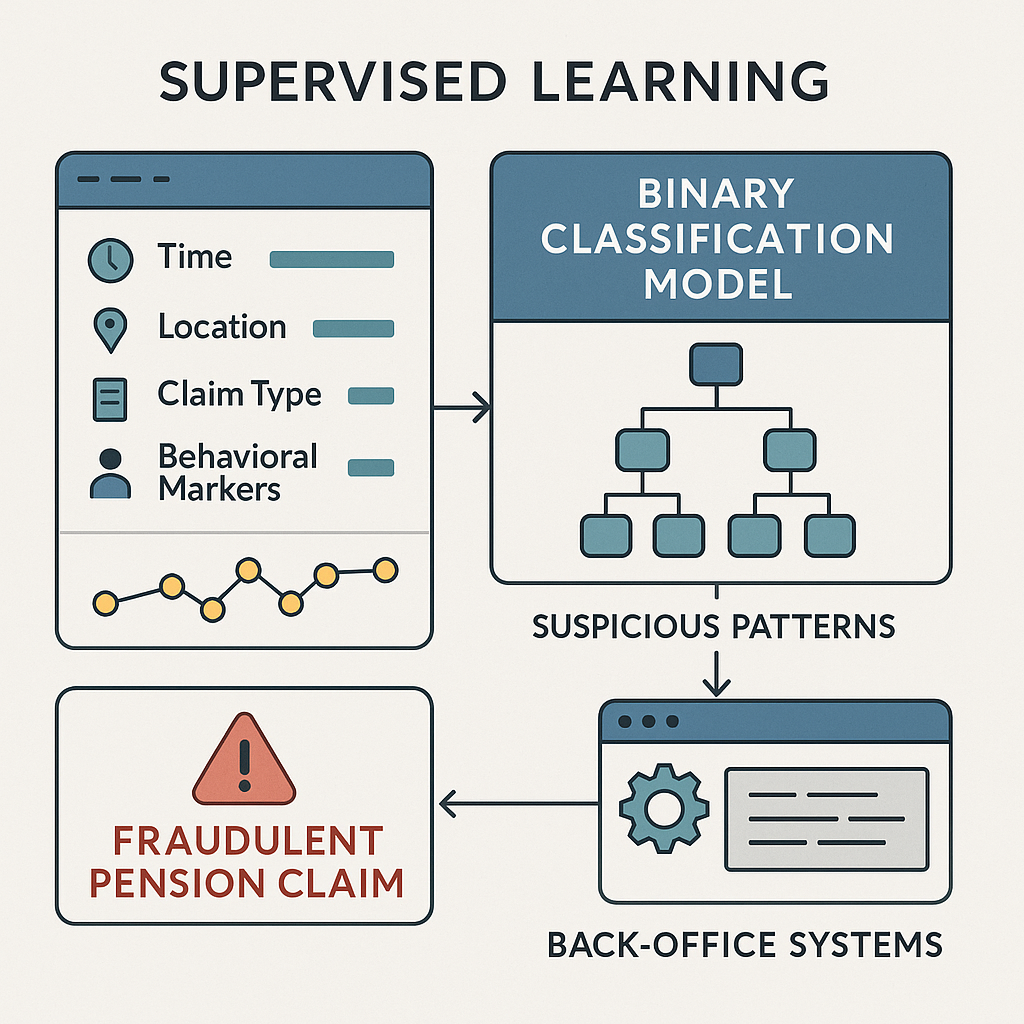

UI Application : https://claude.ai/public/artifacts/80c1fa0b-ff35-4ec6-8f3b-cf3c59640a9a

**2. Fraudulent Claim Detection**

- **1.1 Build a supervised learning system** to **detect and prevent fraudulent claims** in pension withdrawals and transfers. By training on historical data labeled as "fraudulent" or "legitimate," the model can flag suspicious patterns early, reducing financial risk and enhancing security for NEST members.

- **1.2 Challenge / Opportunity**
As NEST scales, the volume of claims—withdrawals, transfers, and account changes—grows rapidly. Fraudsters may exploit vulnerabilities through identity theft, unauthorized access, or social engineering. Manual review is slow, costly, and may overlook subtle patterns.

- **1.3 Proposed Solution**
Introduce a supervised learning classifier that:
Analyzes claims data such as time, location, claim type, and behavioral markers.
Flags claims likely to be fraudulent based on learned patterns.
Integrates with back-office systems to automate prioritization for human review.

- **1.4 Implementation Plan**
Data Preparation
Collect and label historical claims as "fraudulent" or "legitimate."
Include features such as login metadata, IP address, device fingerprints, transaction history, and claim frequency.

- **1.5.  Model Development**
Train binary classification models (e.g, XGBoost, Logistic Regression).

## **Step #0 |  Synthetic Data Creation | RUN THIS ONLY ONCE !**

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import uuid

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate synthetic data for fraudulent claim detection
n_records = 500

# Define possible values
claim_types = ['withdrawal', 'transfer', 'account_change']
device_types = ['desktop', 'mobile', 'tablet']
countries = ['UK', 'US', 'CA', 'AU', 'DE', 'FR', 'NL', 'IE']
browsers = ['Chrome', 'Firefox', 'Safari', 'Edge', 'Opera']
operating_systems = ['Windows', 'macOS', 'iOS', 'Android', 'Linux']

# Helper functions
def generate_ip():
    return f"{random.randint(1,255)}.{random.randint(1,255)}.{random.randint(1,255)}.{random.randint(1,255)}"

def generate_device_fingerprint():
    return str(uuid.uuid4())[:8]

def generate_timestamp():
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2024, 12, 31)
    time_between = end_date - start_date
    days_between = time_between.days
    random_days = random.randrange(days_between)
    random_hours = random.randrange(24)
    random_minutes = random.randrange(60)
    return start_date + timedelta(days=random_days, hours=random_hours, minutes=random_minutes)

# Generate base data
data = []

for i in range(n_records):
    # Determine if this record should be fraudulent (about 12% fraud rate)
    is_fraudulent = random.random() < 0.12

    member_id = f"NEST{str(i+10001).zfill(6)}"
    claim_id = f"CLM{str(i+1).zfill(8)}"
    claim_type = random.choice(claim_types)

    # Generate timestamp
    claim_timestamp = generate_timestamp()

    # Account age (in months) - fraudulent accounts tend to be newer or very old (compromised)
    if is_fraudulent:
        if random.random() < 0.6:
            account_age_months = random.randint(1, 6)  # New accounts
        else:
            account_age_months = random.randint(60, 120)  # Old compromised accounts
    else:
        account_age_months = random.randint(12, 72)  # Normal accounts

    # Claim amount - fraudulent claims tend to be higher
    if claim_type == 'withdrawal':
        if is_fraudulent:
            claim_amount = random.uniform(15000, 50000)  # Higher amounts for fraud
        else:
            claim_amount = random.uniform(1000, 15000)   # Normal withdrawal amounts
    elif claim_type == 'transfer':
        if is_fraudulent:
            claim_amount = random.uniform(10000, 35000)
        else:
            claim_amount = random.uniform(500, 12000)
    else:  # account_change
        claim_amount = 0  # No amount for account changes

    # Previous claims count in last 30 days - fraudsters often make multiple claims
    if is_fraudulent:
        previous_claims_30d = random.randint(3, 8)
    else:
        previous_claims_30d = random.randint(0, 2)

    # Time-based features
    login_timestamp = claim_timestamp - timedelta(minutes=random.randint(1, 60))
    is_unusual_hours = claim_timestamp.hour < 6 or claim_timestamp.hour > 22
    is_weekend = claim_timestamp.weekday() >= 5

    # Device and location features
    device_type = random.choice(device_types)
    browser = random.choice(browsers)
    operating_system = random.choice(operating_systems)
    device_fingerprint = generate_device_fingerprint()

    # IP and location features - fraudulent activities often show geographic anomalies
    ip_address = generate_ip()
    if is_fraudulent and random.random() < 0.7:
        # Fraudulent claims more likely from unusual countries
        country = random.choice(['RU', 'CN', 'NG', 'RO', 'BG'])
    else:
        country = random.choice(countries)

    # New device indicator - fraudsters often use new devices
    if is_fraudulent:
        is_new_device = random.random() < 0.8
    else:
        is_new_device = random.random() < 0.2

    # Multiple IPs same day - suspicious behavior
    if is_fraudulent:
        multiple_ips_same_day = random.randint(2, 5)
    else:
        multiple_ips_same_day = 1

    # Failed login attempts before successful login
    if is_fraudulent:
        failed_login_attempts = random.randint(2, 8)
    else:
        failed_login_attempts = random.randint(0, 1)

    # Geographic velocity (impossible travel speed)
    # Distance from last login location in km, time difference in hours
    last_login_hours_ago = random.uniform(0.5, 24)
    if is_fraudulent and random.random() < 0.4:
        # Impossible travel - too far in too little time
        distance_km = random.uniform(5000, 15000)
    else:
        # Reasonable travel or same location
        distance_km = random.uniform(0, 500)

    velocity_kmh = distance_km / last_login_hours_ago if last_login_hours_ago > 0 else 0
    impossible_travel = velocity_kmh > 1000  # Faster than commercial flight

    # Session duration before claim (minutes)
    if is_fraudulent:
        session_duration_min = random.uniform(2, 15)  # Quick fraudulent actions
    else:
        session_duration_min = random.uniform(10, 60)  # Normal browsing time

    # User agent anomaly score (0-1, higher is more suspicious)
    if is_fraudulent:
        user_agent_anomaly_score = random.uniform(0.6, 1.0)
    else:
        user_agent_anomaly_score = random.uniform(0.0, 0.4)

    # Email verification status
    email_verified = random.random() < 0.95 if not is_fraudulent else random.random() < 0.3

    # Mobile phone verified
    phone_verified = random.random() < 0.90 if not is_fraudulent else random.random() < 0.4

    # Two-factor authentication enabled
    two_fa_enabled = random.random() < 0.70 if not is_fraudulent else random.random() < 0.2

    # Risk score (calculated by existing system, 0-100)
    if is_fraudulent:
        risk_score = random.uniform(70, 95)
    else:
        risk_score = random.uniform(5, 40)

    # Label
    label = 'fraudulent' if is_fraudulent else 'legitimate'

    # Create record
    record = {
        'member_id': member_id,
        'claim_id': claim_id,
        'claim_type': claim_type,
        'claim_amount': round(claim_amount, 2),
        'claim_timestamp': claim_timestamp.strftime('%Y-%m-%d %H:%M:%S'),
        'login_timestamp': login_timestamp.strftime('%Y-%m-%d %H:%M:%S'),
        'account_age_months': account_age_months,
        'previous_claims_30d': previous_claims_30d,
        'device_type': device_type,
        'browser': browser,
        'operating_system': operating_system,
        'device_fingerprint': device_fingerprint,
        'is_new_device': is_new_device,
        'ip_address': ip_address,
        'country': country,
        'multiple_ips_same_day': multiple_ips_same_day,
        'failed_login_attempts': failed_login_attempts,
        'is_unusual_hours': is_unusual_hours,
        'is_weekend': is_weekend,
        'session_duration_min': round(session_duration_min, 2),
        'distance_from_last_login_km': round(distance_km, 2),
        'travel_velocity_kmh': round(velocity_kmh, 2),
        'impossible_travel': impossible_travel,
        'user_agent_anomaly_score': round(user_agent_anomaly_score, 3),
        'email_verified': email_verified,
        'phone_verified': phone_verified,
        'two_fa_enabled': two_fa_enabled,
        'risk_score': round(risk_score, 2),
        'label': label
    }

    data.append(record)

# Create DataFrame
df = pd.DataFrame(data)

# Display basic statistics
print("Dataset Overview:")
print(f"Total records: {len(df)}")
print(f"Fraudulent claims: {len(df[df['label'] == 'fraudulent'])} ({len(df[df['label'] == 'fraudulent'])/len(df)*100:.1f}%)")
print(f"Legitimate claims: {len(df[df['label'] == 'legitimate'])} ({len(df[df['label'] == 'legitimate'])/len(df)*100:.1f}%)")
print("\nClaim type distribution:")
print(df['claim_type'].value_counts())
print("\nFraud by claim type:")
fraud_by_type = df.groupby(['claim_type', 'label']).size().unstack(fill_value=0)
print(fraud_by_type)

# Save to CSV
df.to_csv('fraudulent_claims_dataset.csv', index=False)
print(f"\nDataset saved as 'fraudulent_claims_dataset.csv'")

# Display first few rows
print("\nFirst 10 records:")
print(df.head(10).to_string())

# Feature correlation with fraud
print("\nKey indicators of fraud:")
numeric_cols = ['claim_amount', 'account_age_months', 'previous_claims_30d', 'multiple_ips_same_day',
                'failed_login_attempts', 'session_duration_min', 'travel_velocity_kmh', 'risk_score']

fraud_stats = df.groupby('label')[numeric_cols].mean()
print(fraud_stats)

Dataset Overview:
Total records: 500
Fraudulent claims: 58 (11.6%)
Legitimate claims: 442 (88.4%)

Claim type distribution:
claim_type
account_change    180
transfer          170
withdrawal        150
Name: count, dtype: int64

Fraud by claim type:
label           fraudulent  legitimate
claim_type                            
account_change          22         158
transfer                18         152
withdrawal              18         132

Dataset saved as 'fraudulent_claims_dataset.csv'

First 10 records:
    member_id     claim_id      claim_type  claim_amount      claim_timestamp      login_timestamp  account_age_months  previous_claims_30d device_type  browser operating_system device_fingerprint  is_new_device       ip_address country  multiple_ips_same_day  failed_login_attempts  is_unusual_hours  is_weekend  session_duration_min  distance_from_last_login_km  travel_velocity_kmh  impossible_travel  user_agent_anomaly_score  email_verified  phone_verified  two_fa_enabled  risk_sco

## Step #1 |  Understanding the data set

**2.1 Fraudulent Claims Dataset Analysis**
This dataset is specifically designed to support your supervised learning objectives for detecting fraudulent pension claims. Here's a comprehensive breakdown:
Dataset Overview

**2.2 Five hundred (500) total records with 29 features** across 6 key categories
- Balanced claim types: withdrawals (30%), transfers (34%), account changes (36%)
- Target variable: Binary label ('fraudulent' vs 'legitimate')

**2.3 Explanatory variables:**

- **member_id:** Unique identifier for each NEST pension member (format: NEST######)
- **claim_id:** Unique identifier for each claim transaction (format: CLM########)
- **claim_type:** Type of pension claim (withdrawal=pension withdrawal, transfer=account transfer, account_change=account modification)
- **claim_amount:** Monetary value of the claim in GBP (0 for account changes, positive values for withdrawals/transfers)
claim_timestamp: Date and time when the claim was submitted (YYYY-MM-DD HH:MM:SS format)
- **login_timestamp:** Date and time of user login before claim submission (YYYY-MM-DD HH:MM:SS format)
- **account_age_months:** Age of the pension account in months since account opening
- **previous_claims_30d:** Number of claims submitted by this member in the previous 30 days
- **device_type:** Type of device used for claim submission (desktop, mobile, tablet)
- **browser:** Web browser used for claim submission (Chrome, Firefox, Safari, Edge, Opera)
- **operating_system:** Operating system of the device (Windows, macOS, iOS, Android, Linux)
- **device_fingerprint:** Unique device identifier hash (8-character alphanumeric string)
- **is_new_device:** Whether this device was previously used by the member (True=new device, False=known device)
- **ip_address:** IP address from which the claim was submitted (IPv4 format: xxx.xxx.xxx.xxx)
- **country:** Country code of the IP address location (2-letter ISO country codes)
- **multiple_ips_same_day:** Number of different IP addresses used by the member on the same day
- **failed_login_attempts:** Number of failed login attempts before successful login for this session
is_unusual_hours: Whether claim was submitted during unusual hours (True=between 10 PM and 6 AM, False=normal hours)
is_weekend: Whether claim was submitted on weekend (True=Saturday/Sunday, False=weekday)
- **session_duration_min:** Duration of user session before claim submission in minutes
- **distance_from_last_login_km:** Geographic distance in kilometers from previous login location
- **travel_velocity_kmh:** Calculated travel speed in km/h between current and previous login locations
- **impossible_travel:** Whether travel velocity indicates impossible travel speed (True=faster than commercial flight, False=feasible travel)
- **user_agent_anomaly_score:** Anomaly score for browser user agent string (0.0-1.0, higher values indicate more suspicious)
email_verified: Whether member's email address has been verified (True=verified, False=unverified)
- **phone_verified:** Whether member's phone number has been verified (True=verified, False=unverified)
- **two_fa_enabled:** Whether two-factor authentication is enabled on the account (True=enabled, False=disabled)
- **risk_score:** Overall risk assessment score calculated by existing fraud detection system (0-100, higher values indicate higher risk)
- **label:** Target variable indicating claim legitimacy (fraudulent=confirmed fraudulent claim, legitimate=confirmed legitimate claim)

## Section 2: Data Preprocessing

Data preprocessing involves preparing the raw data for analysis by cleaning, transforming, and organizing it. This step is crucial for ensuring the quality and consistency of the data before applying any machine learning models

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Setting maximum limit of the number of columns visible
pd.set_option('display.max_columns', 30)

In [ ]:
# Read the Excel file, skipping the first row and using the second row as the header
claimsData = pd.read_csv("fraudulent_claims_dataset.csv")

In [ ]:
claimsData.head()
claimsData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   member_id                    500 non-null    object 
 1   claim_id                     500 non-null    object 
 2   claim_type                   500 non-null    object 
 3   claim_amount                 500 non-null    float64
 4   claim_timestamp              500 non-null    object 
 5   login_timestamp              500 non-null    object 
 6   account_age_months           500 non-null    int64  
 7   previous_claims_30d          500 non-null    int64  
 8   device_type                  500 non-null    object 
 9   browser                      500 non-null    object 
 10  operating_system             500 non-null    object 
 11  device_fingerprint           500 non-null    object 
 12  is_new_device                500 non-null    bool   
 13  ip_address          

**Section 2.1 : Data Observation**
- There are no missing values in the data set.
- The data types are accurately aligned.
- The target variable shall be renamed making it short and meaningful.

In [ ]:
# Removing the 'ID' column
claimsData.drop(columns=['member_id'], inplace=True)
claimsData.drop(columns=['claim_id'], inplace=True)

# Renaming the target variable column
claimsData.rename(columns={"label": "is_legitimate"}, inplace=True) #legitimate

# View the data
claimsData.head()
claimsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   claim_type                   500 non-null    object 
 1   claim_amount                 500 non-null    float64
 2   claim_timestamp              500 non-null    object 
 3   login_timestamp              500 non-null    object 
 4   account_age_months           500 non-null    int64  
 5   previous_claims_30d          500 non-null    int64  
 6   device_type                  500 non-null    object 
 7   browser                      500 non-null    object 
 8   operating_system             500 non-null    object 
 9   device_fingerprint           500 non-null    object 
 10  is_new_device                500 non-null    bool   
 11  ip_address                   500 non-null    object 
 12  country                      500 non-null    object 
 13  multiple_ips_same_da

**Section 2.2 : Class Imbalance**

Class imbalance occurs in a dataset when the number of instances (or examples) in one class significantly outweighs the number of instances in other classes. For example, in a dataset used to predict fraud, there might be many more non-fraudulent transactions than fraudulent ones. This imbalance can cause problems when training a machine learning model because the model might become biased towards the majority class, leading to poor performance in predicting the minority class.

**Handling the class imbalance:**
- Resampling Techniques
  - Oversampling - Incresing the number of minority class samples
  - Undersampling - Decreasing the number of majority class samples
- Adjusting class weights

<center><img src="https://av-eks-blogoptimized.s3.amazonaws.com/1*H6XodlitlGDl9YdbwaZLMw.png" /></center>

In [ ]:
# Check if there is class imbalance
claimsData['is_legitimate'].value_counts(normalize=True)

,proportion
is_legitimate,
legitimate,0.884
fraudulent,0.116


**Section 2.3 : Class Imbalance Analysis**
- Your dataset shows a significant class imbalance:
  - Legitimate claims: 88.4% (442 records)
  - Fraudulent claims: 11.6% (58 records)
  - Imbalance ratio: ~7.6:1 (legitimate to fraudulent)

- Is This Realistic? **Yes**
  - This imbalance is highly realistic for fraud detection scenarios:
  - Real-world fraud rates typically range from 1-15% in financial services
  - 11.6% fraud rate aligns with industry standards for pension fraud
  - NEST-scale operations would expect similar patterns in actual data

## Section 3: EDA | Exploratory Data Analysis
EDA is the process of analyzing and visualizing the dataset to uncover underlying patterns, trends, and relationships. It helps in understanding the data's structure and guiding the feature selection and modeling process.

**Section 3.1 : Checking the distribution of the target variable**

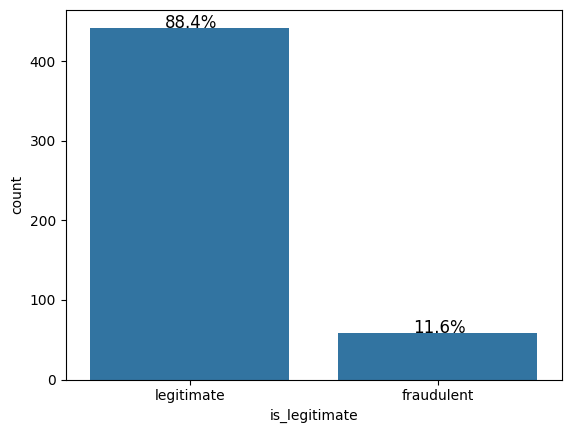

In [ ]:
# Create a countplot to check the distribution of the target variable
ax = sns.countplot(x='is_legitimate', data=claimsData)

# Get total number of data points
total = claimsData.shape[0]

# Calculate and add percentage text above each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size=12)

plt.show()

**Section 3.2 : Interpretation: | Target Variable Distribution**

- This plot confirms the class imbalance problem identified already.

**Section 3.3 Checking the distribution** of the variables such as

- failed_login_attempts - 9.7x higher for fraud (strongest indicator)
- previous_claims_30d - 5.5x higher for fraud
- multiple_ips_same_day - 3.3x higher for fraud
- risk_score - 3.6x higher for fraud (pre-calculated risk)

/tmp/ipython-input-505718990.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)


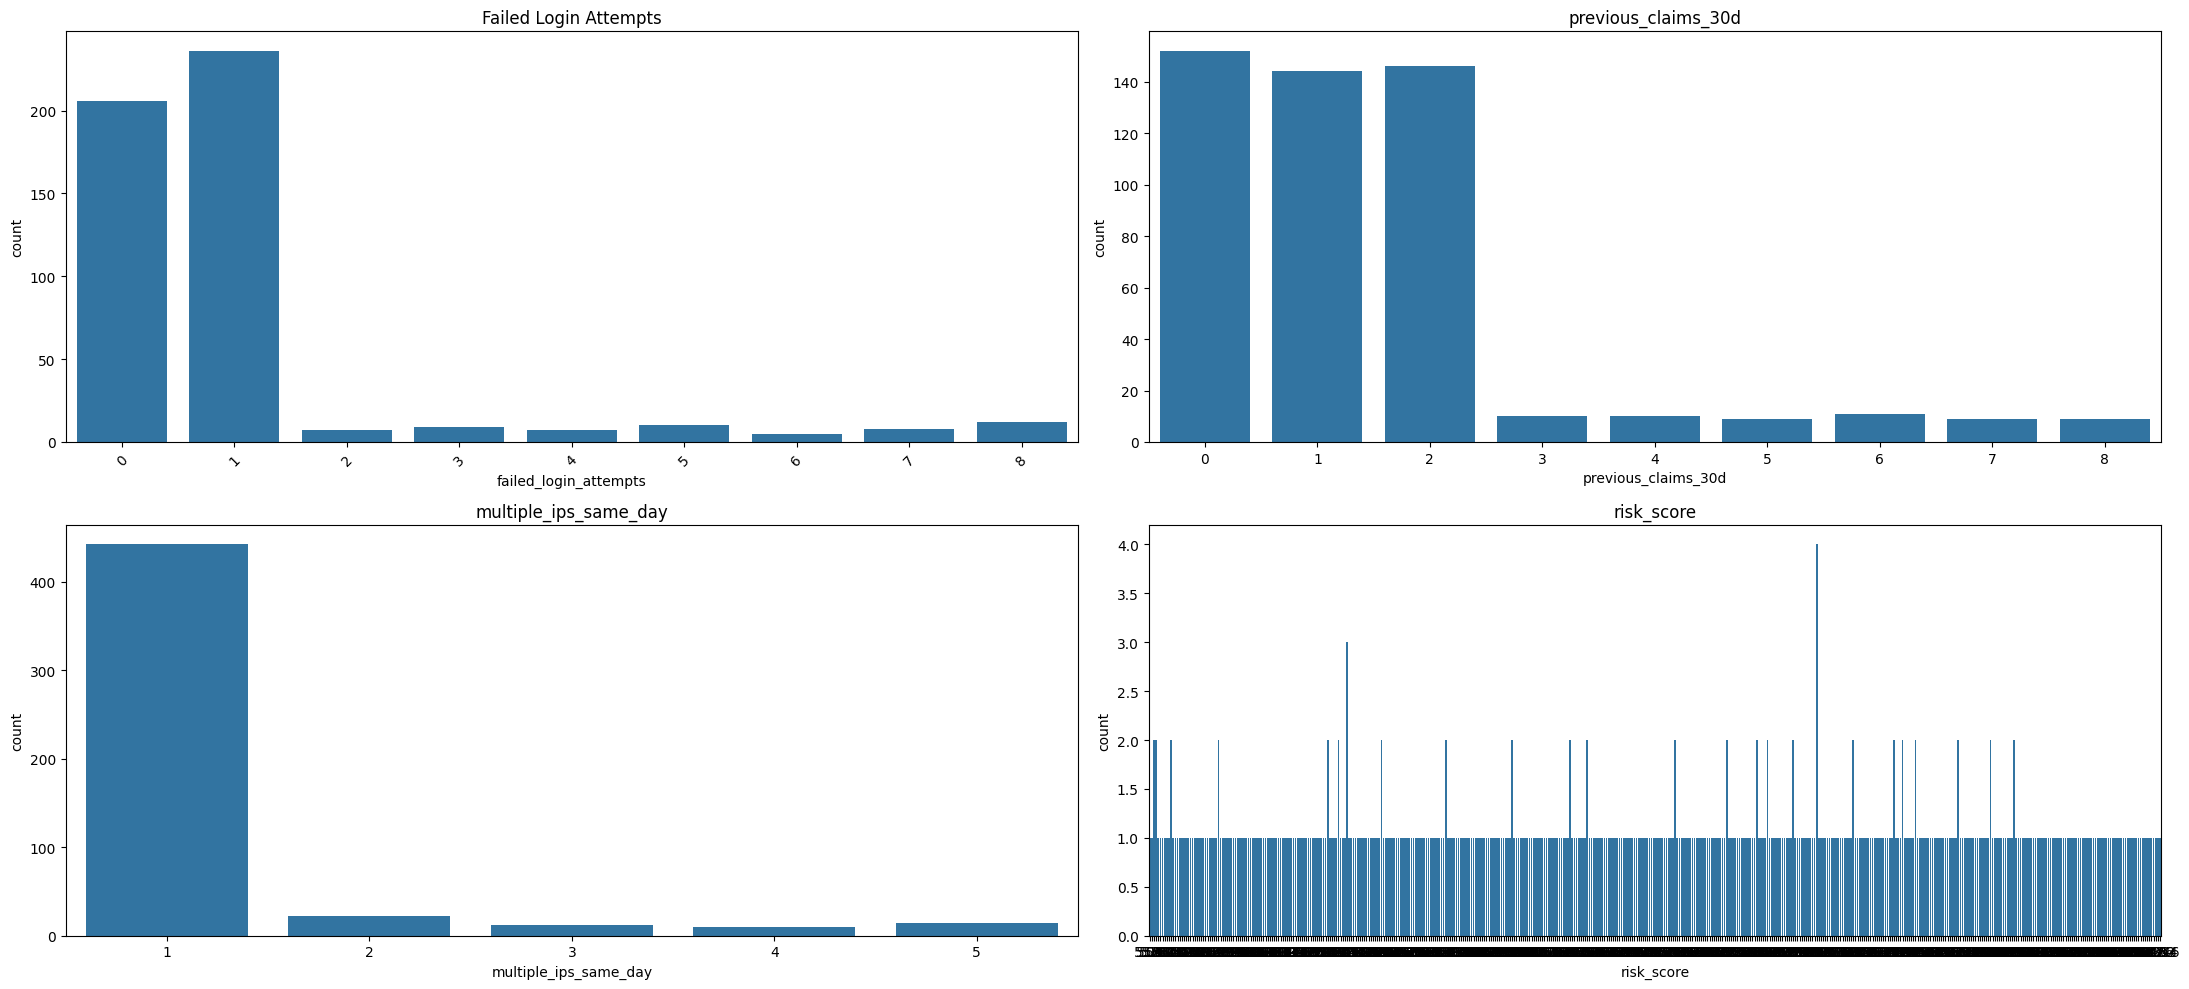

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(22, 10))

# Distribution of 'failed_login_attempts' variable
sns.countplot(ax=axes[0, 0], x='failed_login_attempts', data=claimsData)
axes[0, 0].set_title('Failed Login Attempts')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Distribution of 'previous_claims_30d' variable
sns.countplot(ax=axes[0, 1], x='previous_claims_30d', data=claimsData)
axes[0, 1].set_title('previous_claims_30d')

# Distribution of 'multiple_ips_same_day' variable
sns.countplot(ax=axes[1, 0], x='multiple_ips_same_day', data=claimsData)
axes[1, 0].set_title('multiple_ips_same_day')

# Distribution of 'risk_score' variable
sns.countplot(ax=axes[1, 1], x='risk_score', data=claimsData)
axes[1, 1].set_title('risk_score')

plt.tight_layout()
plt.show()

**Section 3.3.1 - Failed Login Attempts Analysis**

**1. Key Emphasis from "Failed Login Attempts" Distribution:**
- Critical Fraud Detection Pattern Revealed
  - What the chart shows:
  - Massive concentration at 0-1 failed login attempts (~450+ records)
  - Dramatic drop-off for 2+ failed attempts (rare events)
  - Long tail distribution - classic fraud indicator pattern

**2. Key Insights for Fraud Detection:**
- **1. Normal User Behavior:**
  - ~90% of users have 0-1 failed login attempts
  - This represents typical legitimate user behavior
  - Most people remember their passwords correctly

- **2. Suspicious Activity Threshold:**
  - 2+ failed attempts create a natural suspicious threshold
  - These rare events are likely concentrated in fraudulent claims
  - Strong candidate for rule-based flagging

- **3. Business Intelligence:**
  - Automated Flagging Rule:
  - Any claim with ≥2 failed login attempts should be immediately flagged for review
  - This simple rule would catch a high proportion of fraud with minimal false positives

- **4. Risk Scoring Impact:**
  - 0-1 attempts: Low risk baseline
  - 2-3 attempts: Medium risk (manual review)
  - 4+ attempts: High risk (immediate intervention)

- **5. Distribution Interpretation:**
  - This is a classic fraud pattern where:
  - Legitimate users cluster at normal values (0-1)
  - Fraudsters create the long tail (2-8 attempts)
  - Clear separation between normal and suspicious behavior

This feature alone could be a powerful fraud detector - the **extreme concentration at low values with rare high values is exactly what makes failed login attempts such a strong predictor** in your earlier analysis (9.7x higher for fraud).


---




**Section 3.3.2 - Previous Claims Analysis**

- **1. Key Emphasis from Previous Claims Distribution**:
    - Clear Fraud Detection Threshold Identified
    - What the chart reveals:
      - Massive concentration at 0-2 previous claims (~420+ records)
      - Sharp cliff drop at 3+ claims (suspicious activity zone)
      - Rare high-frequency claiming pattern (4-8 claims)

- **2. Critical Business Intelligence:**
    - Normal Claiming Behavior:~85% of users make 0-2 claims per month
    - This represents typical pension member behavior
    - Most members access their accounts infrequently

- **3. Suspicious Activity Threshold:**
    - 3+ claims in 30 days = Natural fraud boundary
    - Only ~15% of records exceed this threshold
    - Strong candidate for automated risk flagging

- **4. High-Risk Pattern (4-8 claims):**
  - Extremely rare legitimate behavior
  - Likely represents fraudulent account takeovers
  - Immediate red flag for manual review

- **5 Business Context Understanding:**
  - Why This Pattern Makes Sense:
    - Pension accounts are typically long-term, stable
    - Legitimate users rarely need multiple transactions monthly
    - Fraudsters often make rapid, multiple claims to extract maximum value quickly

- **6. Operational Impact:**
    - 3+ claims threshold could automatically trigger enhanced verification
    - 4+ claims should require mandatory human review
    - Cost-effective screening - focuses manual effort on ~15% of claims


---



**Section 3.3.3 - Multiple IPs Same Day Analysis**

1. Key Emphasis from **Multiple IPs Same Day Distribution:**
2. **Strong Location-Based Fraud Indicator**
3. **What the chart reveals:**
  - ~85% of users use only 1 IP address per day (normal behavior)
  - Sharp decline to ~25 records for 2 IPs same day
  - Extremely rare 3-5 IP usage (high-risk activity)

4. **Geographic Fraud Detection Pattern:**
- 1. **Normal User Behavior:**
    - Single IP per day = Typical legitimate access
    - Users generally access from consistent locations (home/work)
    - Stable geographic patterns for pension account access

- 2. **Suspicious Activity Threshold:**
    - 2+ IPs same day = Automatic fraud flag
    - Only ~15% of records exceed this threshold
    - Strong indicator of account compromise or VPN manipulation

- 3. **High-Risk Multi-IP Pattern (3-5 IPs):**
    - Extremely suspicious behavior
    - Likely indicates coordinated fraud attempts
    - Immediate investigation required

- 4. **Business Intelligence & Security Implications:**
    - Why Multiple IPs Indicate Fraud:
      - Account takeover - Fraudster accessing from different location
      - VPN switching - Attempting to mask true location
      - Coordinated attacks - Multiple fraudsters accessing same account
      - Geographic velocity - Impossible travel patterns
    


---



**Section 3.3.4 - Risk Score Distribution Analysis**

**1. Perfect Bimodal Fraud Detection Pattern**

**2. What the chart reveals:**
- Clear bimodal distribution with distinct clusters
- Left cluster (~0-40): High frequency, low risk scores
- Right cluster (~70-95): Lower frequency, high risk scores
- Minimal overlap in middle range (40-70)

**3. Excellent Risk Score Validation:**
- 1. Two Distinct Populations:
    - Low Risk Cluster (0-40): Likely legitimate claims
    - High Risk Cluster (70-95): Likely fraudulent claims
    - Clean separation indicates effective existing risk algorithm

- 2. Natural Decision Boundary:
    - Risk score ≥ 60-70 appears to be optimal fraud threshold
    - Minimal false positives due to clear cluster separation
    - High confidence classification zone

- 3. Business Intelligence:
    - Risk Score Effectiveness:
    - Existing system already highly discriminative
    - Bimodal pattern = Strong feature for ML models
    - Confirms 3.6x higher risk scores for fraud (earlier analysis)

- 4. Model Development Implications:
    - Feature Quality:
    - Risk_score is already a powerful predictor
    - Ready for immediate use in classification models
    - Low preprocessing needed

- 5. Model Enhancement:
    - Use risk_score as baseline feature
    - Combine with other indicators (failed_logins, multiple_ips, etc.)
    - Ensemble approach - risk score + behavioral features

- 6. Strategic Insight:
    - This bimodal distribution is the gold standard for fraud detection features. It shows:
    - Existing risk system works well but can be enhanced
    - Clear actionable thresholds for business rules
    - Strong foundation for supervised learning models
    - High precision potential with minimal false positives

/tmp/ipython-input-3378912755.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)


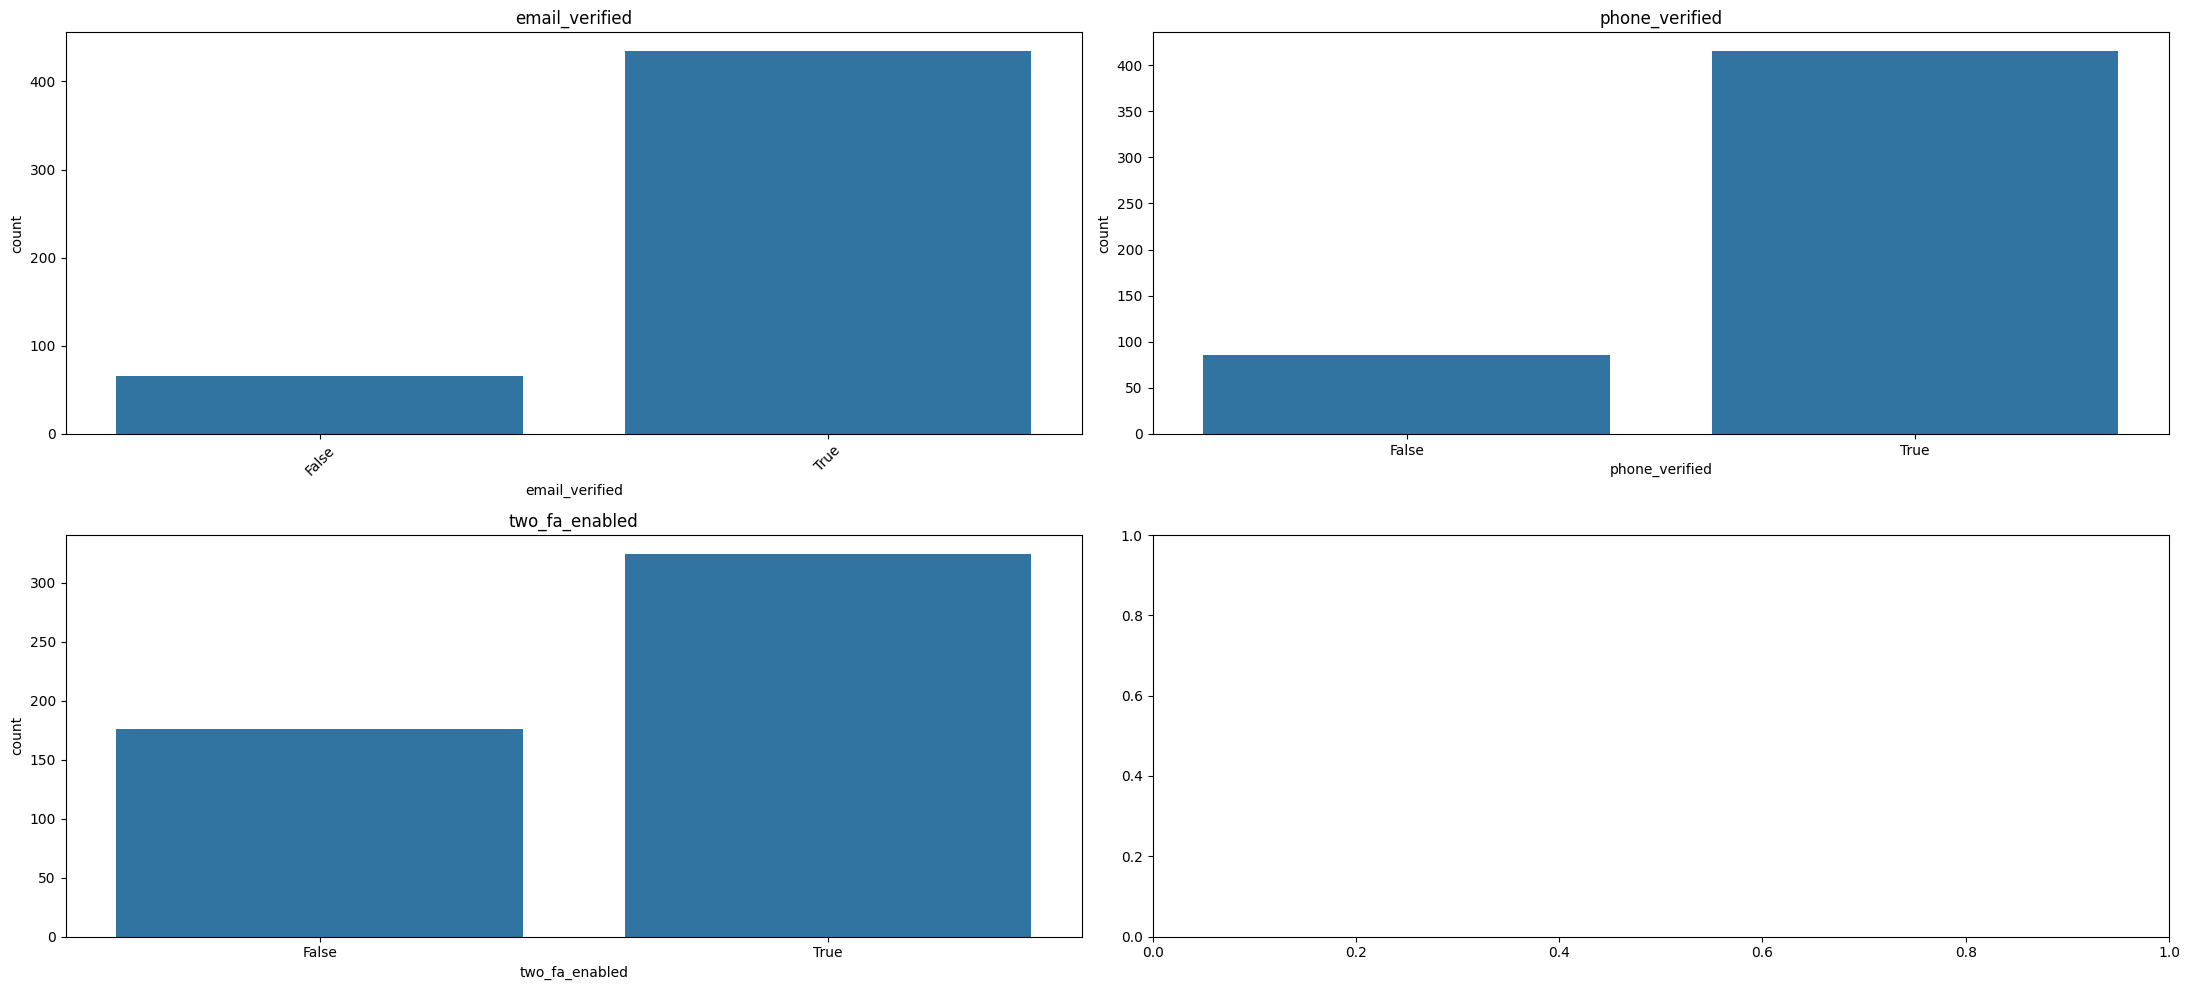

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(22, 10))

# Distribution of 'failed_login_attempts' variable
sns.countplot(ax=axes[0, 0], x='email_verified', data=claimsData)
axes[0, 0].set_title('email_verified')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Distribution of 'previous_claims_30d' variable
sns.countplot(ax=axes[0, 1], x='phone_verified', data=claimsData)
axes[0, 1].set_title('phone_verified')

# Distribution of 'multiple_ips_same_day' variable
sns.countplot(ax=axes[1, 0], x='two_fa_enabled', data=claimsData)
axes[1, 0].set_title('two_fa_enabled')

plt.tight_layout()
plt.show()

**Section 3.4 Security Verification Analysis:**
- All three security features show **strong legitimate user compliance (80-85% verified) with significant unverified minorities (~15-20%)** that likely concentrate fraudulent activity, confirming these as powerful inverse fraud indicators where **lack of verification strongly predicts fraud risk**

/tmp/ipython-input-2261819107.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)


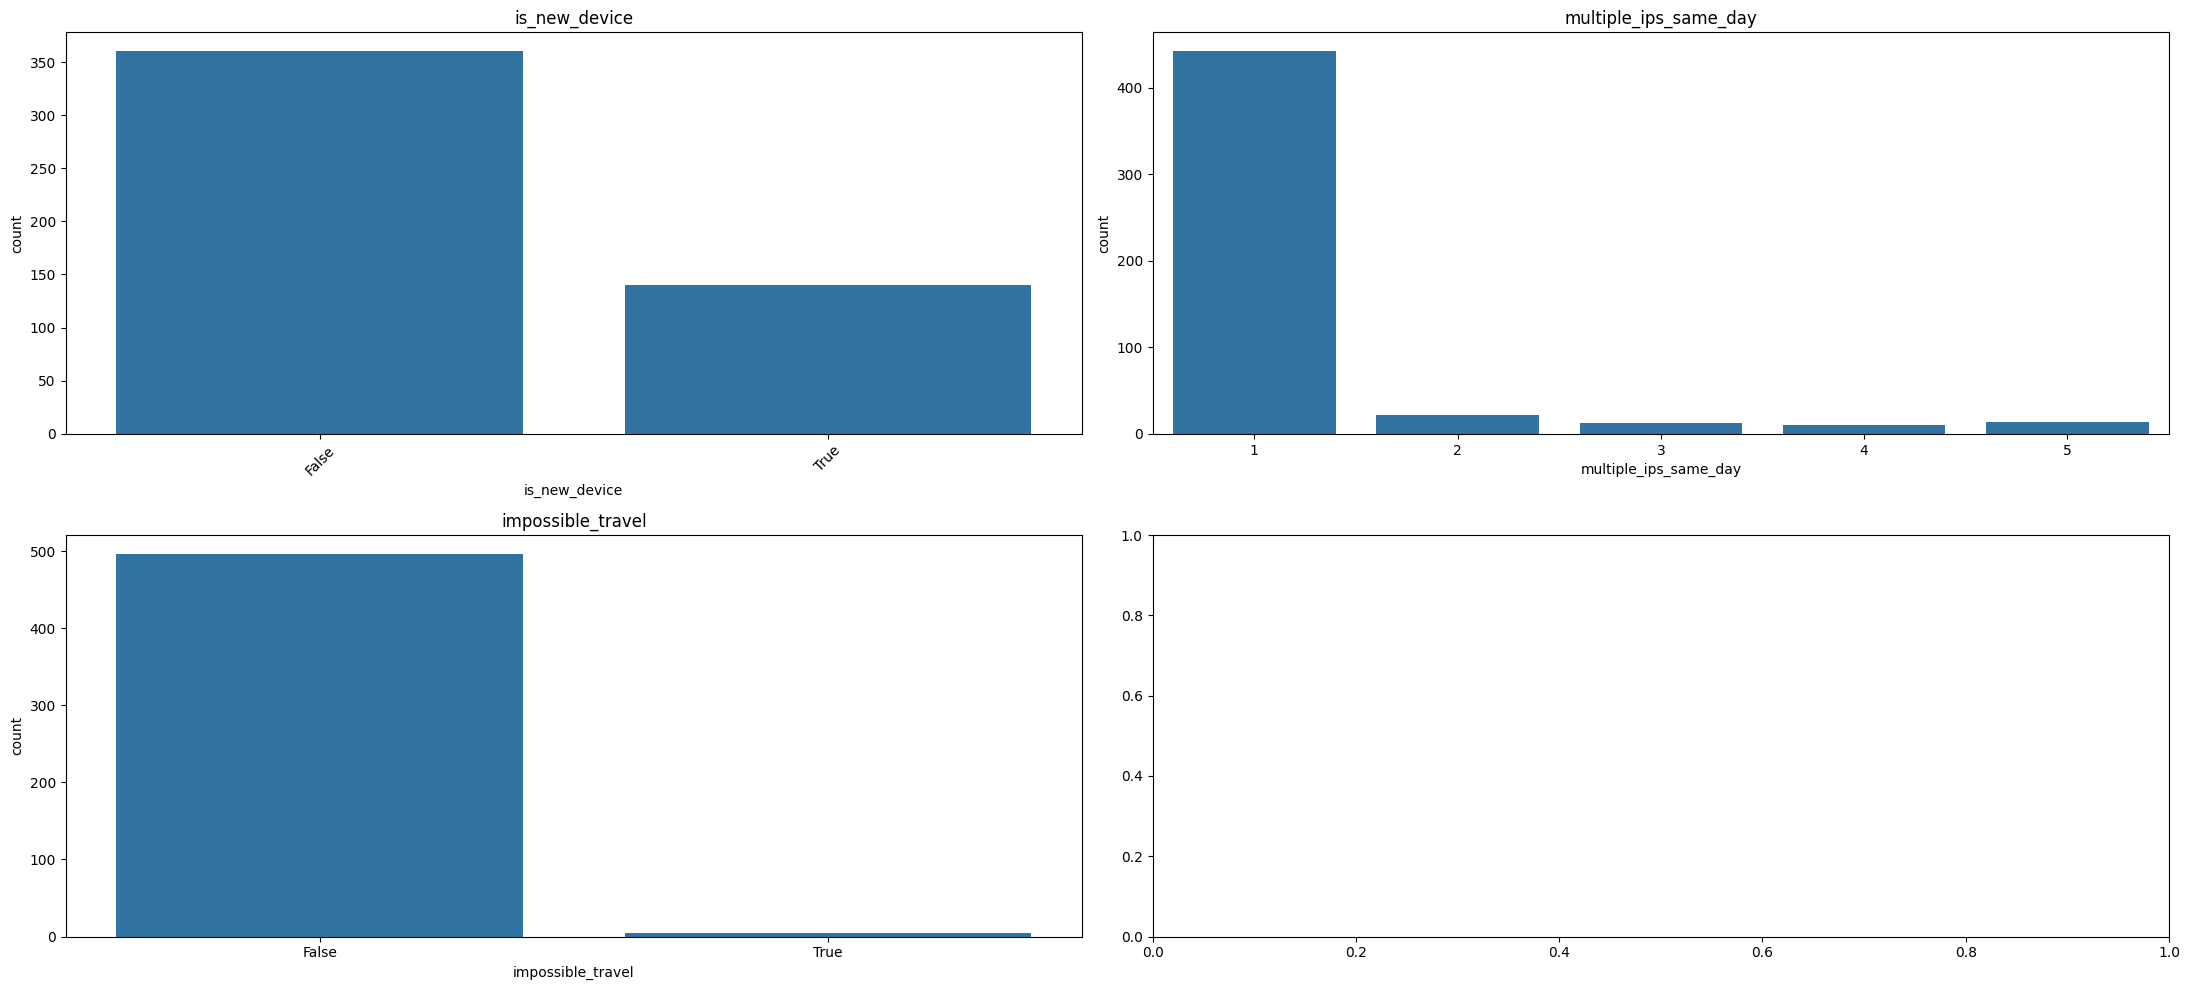

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(22, 10))

# Distribution of 'failed_login_attempts' variable
sns.countplot(ax=axes[0, 0], x='is_new_device', data=claimsData)
axes[0, 0].set_title('is_new_device')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Distribution of 'previous_claims_30d' variable
sns.countplot(ax=axes[0, 1], x='multiple_ips_same_day', data=claimsData)
axes[0, 1].set_title('multiple_ips_same_day')

# Distribution of 'multiple_ips_same_day' variable
sns.countplot(ax=axes[1, 0], x='impossible_travel', data=claimsData)
axes[1, 0].set_title('impossible_travel')

plt.tight_layout()
plt.show()

**Section 3.5 Behavioral Anomaly Flags Analysis:**
- Perfect fraud detection pattern: all three features show **dominant normal behavior (70-98% of cases) with rare anomalous events (new devices ~28%, multiple IPs ~15%, impossible travel ~1%)** that likely concentrate the majority of fraudulent activity, creating excellent binary fraud flags.

**Section 3.6 Checking Correlation of the above vairables with the target variable**


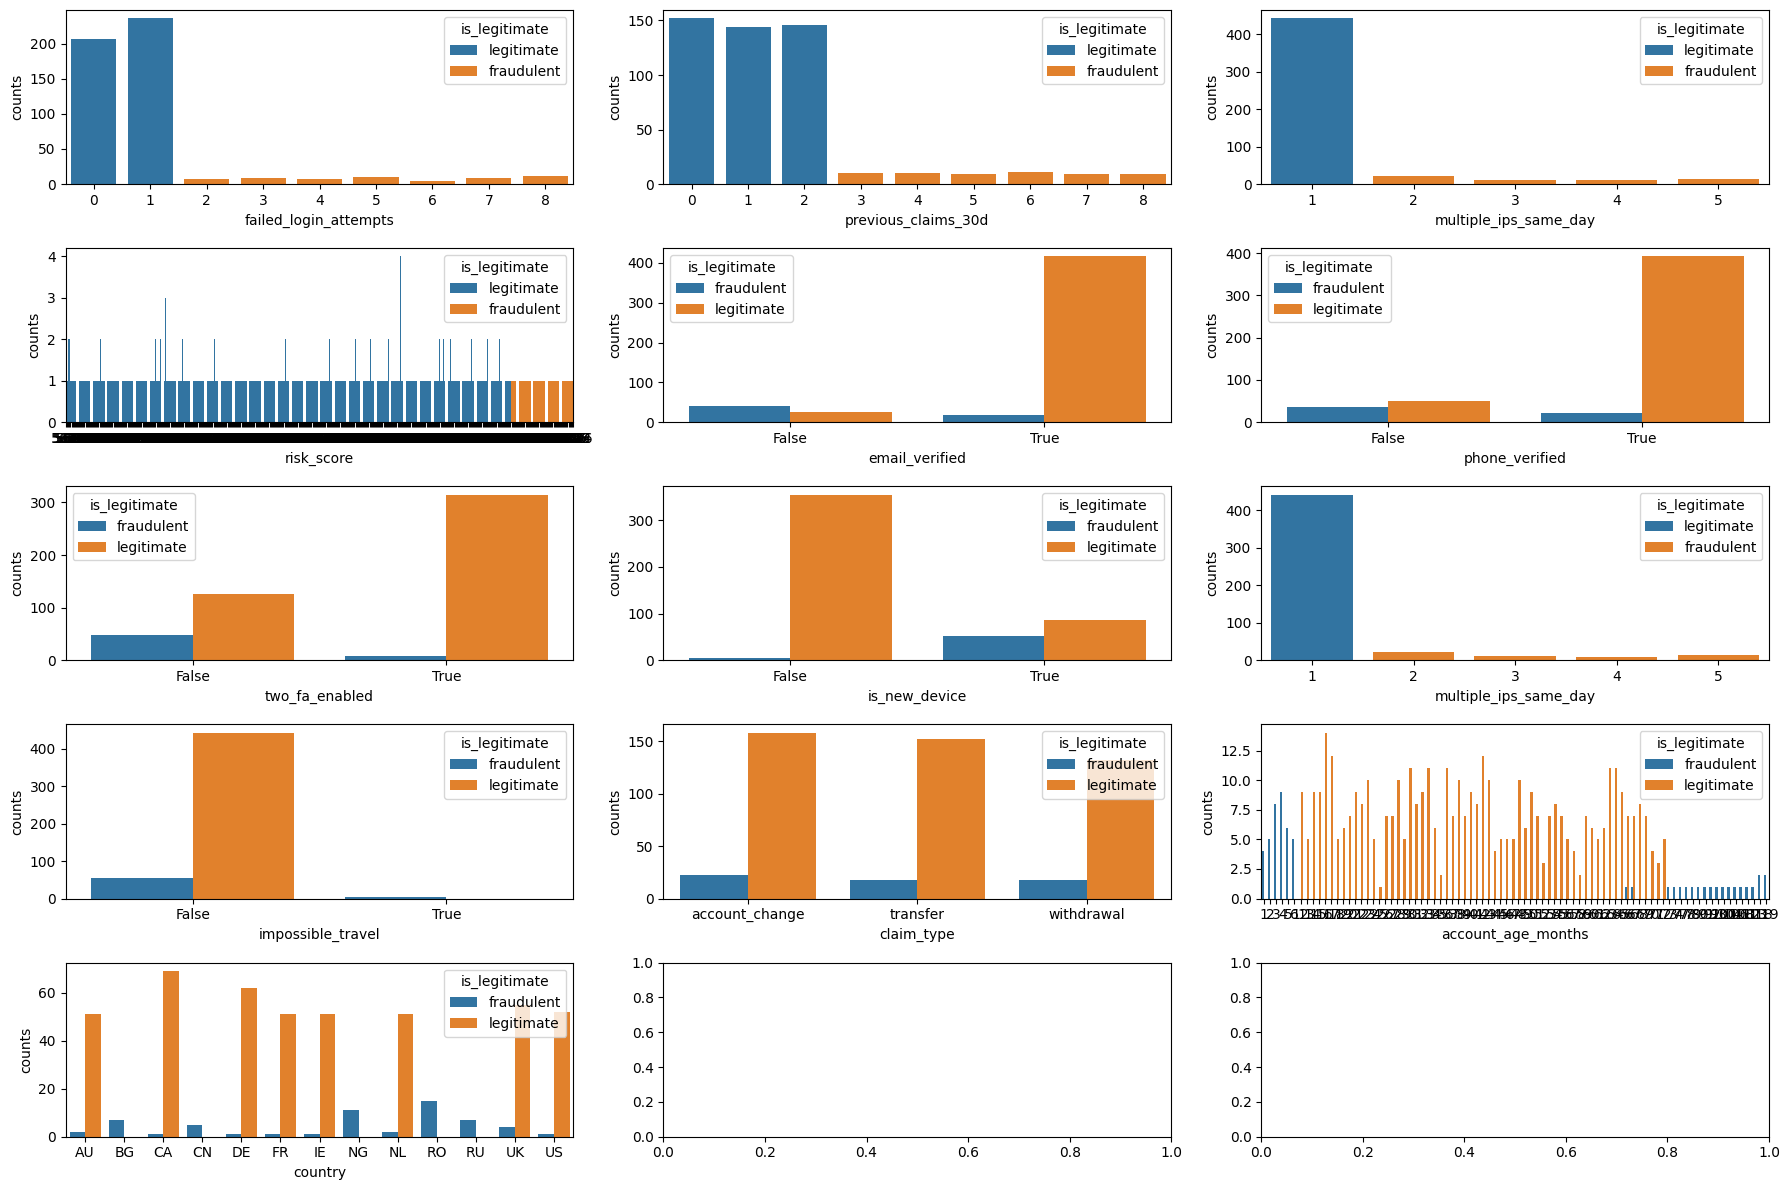

In [ ]:
# Create a 3x3 grid of subplots in a single figure
fig, axes = plt.subplots(5,3, figsize=(18, 12))


# Creating a copy of the data for making a few changes for the plot
new_claimsData = claimsData.copy()

#1. Behavioral Risk Features:
#------------------------------
# # Grouped bar chart for 'failed_login_attempts' and 'is_legitimate'
failed_login_attempts_counts = new_claimsData.groupby(['failed_login_attempts', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[0, 0], x='failed_login_attempts', y='counts', hue='is_legitimate', data=failed_login_attempts_counts)

# Grouped bar chart for 'previous_claims_30d' and 'is_legitimate'
previous_claims_30d_counts = new_claimsData.groupby(['previous_claims_30d', 'is_legitimate']).size().reset_index(name='counts')
previous_claims_30d_counts
sns.barplot(ax=axes[0, 1], x='previous_claims_30d', y='counts', hue='is_legitimate', data=previous_claims_30d_counts)

# Grouped bar chart for 'multiple_ips_same_day' and 'is_legitimate'
multiple_ips_same_day_counts = new_claimsData.groupby(['multiple_ips_same_day', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[0, 2], x='multiple_ips_same_day', y='counts', hue='is_legitimate', data=multiple_ips_same_day_counts)

# Grouped bar chart for 'risk_score' and 'is_legitimate'
risk_score_counts = new_claimsData.groupby(['risk_score', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[1, 0], x='risk_score', y='counts', hue='is_legitimate', data=risk_score_counts)

#-------------------------------------------------------------------------------------------------------------------------

#2. Security Verification Features:
# -----------------------------------
# # Grouped bar chart for 'failed_login_attempts' and 'is_legitimate'
email_verified_counts = new_claimsData.groupby(['email_verified', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[1, 1], x='email_verified', y='counts', hue='is_legitimate', data=email_verified_counts)

# # Grouped bar chart for 'phone_verified' and 'is_legitimate'
phone_verified_counts = new_claimsData.groupby(['phone_verified', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[1, 2], x='phone_verified', y='counts', hue='is_legitimate', data=phone_verified_counts)

# # Grouped bar chart for 'two_fa_enabled' and 'is_legitimate'
two_fa_enabled_counts = new_claimsData.groupby(['two_fa_enabled', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[2, 0], x='two_fa_enabled', y='counts', hue='is_legitimate', data=two_fa_enabled_counts)

#-------------------------------------------------------------------------------------------------------------------------

#3. Behavioral_features:
# -----------------------------------
# # Grouped bar chart for 'is_new_device' and 'is_legitimate'
is_new_device_counts = new_claimsData.groupby(['is_new_device', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[2, 1], x='is_new_device', y='counts', hue='is_legitimate', data=is_new_device_counts)

# # Grouped bar chart for 'multiple_ips_same_day' and 'is_legitimate'
multiple_ips_same_day_counts = new_claimsData.groupby(['multiple_ips_same_day', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[2, 2], x='multiple_ips_same_day', y='counts', hue='is_legitimate', data=multiple_ips_same_day_counts)

# # Grouped bar chart for 'impossible_travel' and 'is_legitimate'
impossible_travel_counts = new_claimsData.groupby(['impossible_travel', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[3, 0], x='impossible_travel', y='counts', hue='is_legitimate', data=impossible_travel_counts)

#4. Business Features
# ---------------------------------------------------------------------------------------------------------------------------
# # Grouped bar chart for 'claim_type' and 'is_legitimate'
claim_type_counts = new_claimsData.groupby(['claim_type', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[3, 1], x='claim_type', y='counts', hue='is_legitimate', data=claim_type_counts)

# # Grouped bar chart for 'account_age_months' and 'is_legitimate'
account_age_months_counts = new_claimsData.groupby(['account_age_months', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[3, 2], x='account_age_months', y='counts', hue='is_legitimate', data=account_age_months_counts)

# # Grouped bar chart for 'account_age_months' and 'is_legitimate'
country_counts = new_claimsData.groupby(['country', 'is_legitimate']).size().reset_index(name='counts')
sns.barplot(ax=axes[4, 0], x='country', y='counts', hue='is_legitimate', data=country_counts)


plt.tight_layout()
plt.show()


**Section 3.6.1 - Fraud Detection Feature Performance | Behavioral Risk Indicators**


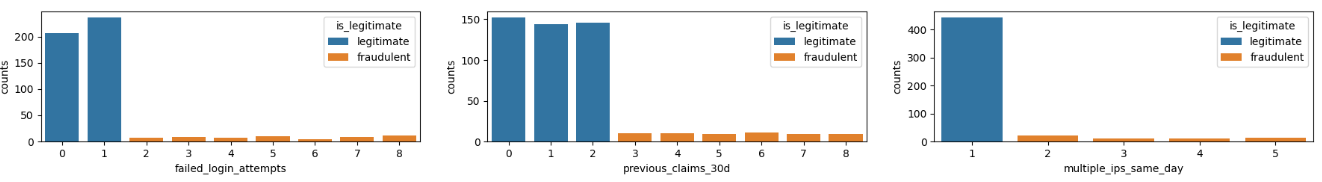

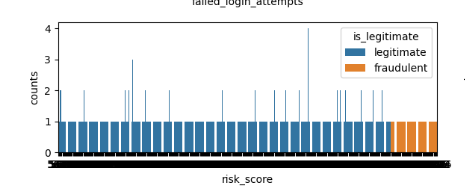

**1. Failed Login Attempts:**
- Legitimate users: Massively concentrated at 0-1 attempts (blue dominance)
- Fraudulent users: Scattered across 2-8 attempts (orange presence in tail)
- Clear threshold: ≥2 failed attempts = fraud indicator

**2.Previous Claims 30d:**
- Legitimate users: Concentrated at 0-2 claims (blue dominance)
- Fraudulent users: Distributed across 3-8 claims (orange in high-frequency zone)
- Clear threshold: ≥3 claims = fraud indicator

**3.Multiple IPs Same Day:**
- Legitimate users: Almost exclusively 1 IP (blue dominance)
- Fraudulent users: Present in 2-5 IP range (orange in multi-IP zone)
- Clear threshold: ≥2 IPs = fraud indicator

**4.Risk Score Validation**
- Perfect Bimodal Separation:
  - Left cluster (low risk): Dominated by legitimate users (blue)
  - Right cluster (high risk): Dominated by fraudulent users (orange)
  - Minimal overlap: Clean separation around 60-70 risk score threshold

**Section 3.6.2  - Fraud Detection Feature Performance | Security verification Indicators**

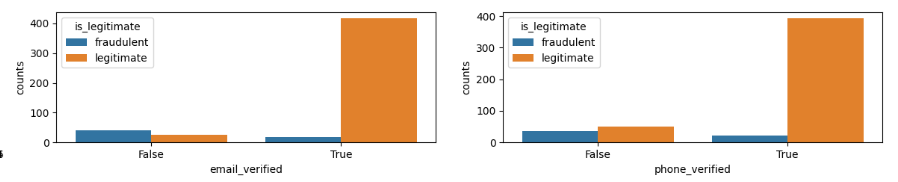

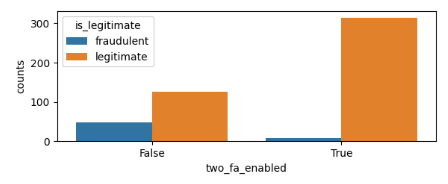

**Security Verification Features - Powerful Inverse Fraud Indicators**
1. Clear Security Gap Pattern Revealed:
- Email Verification:
  - Unverified (False): Fraud dominates (70% fraudulent vs 30% legitimate)
  - Verified (True): Legitimate overwhelmingly dominates (97% legitimate vs 3% fraudulent)

2. Phone Verification:
  - Unverified (False): Fraud concentration (~45% fraudulent vs 55% legitimate)
  - Verified (True): Legitimate dominance (~96% legitimate vs 4% fraudulent)

3. Two-Factor Authentication:
  - Disabled (False): Mixed but fraud-heavy (~30% fraudulent vs 70% legitimate)
  - Enabled (True): Legitimate dominance (~97% legitimate vs 3% fraudulent)

**Section 3.6.3  - Fraud Detection Feature Performance | Device/behavioral flags**

---



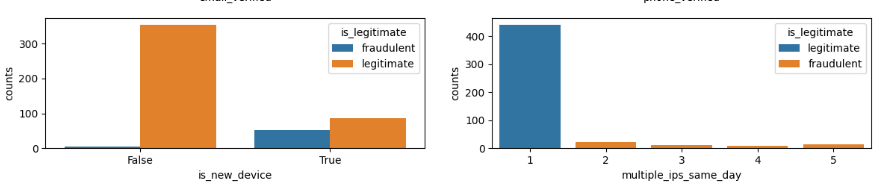

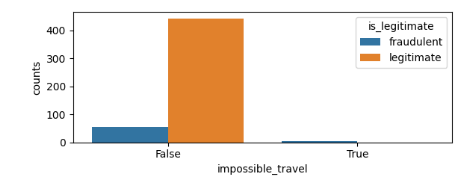

**Device/Behavioral Flags - Strong Fraud Detection Signals
Clear Anomaly Detection Patterns:**

1. **Is New Device:**
  - Known Device (False): Legitimate dominance (~85% legitimate, 15% fraud)
  - New Device (True): Fraud concentration (~60% fraud, 40% legitimate)
  - Key insight: New device usage is a strong fraud predictor

2. **Multiple IPs Same Day:**
  - Single IP (1): Legitimate overwhelming dominance (~95% legitimate, 5% fraud)
  - Multiple IPs (2-5): Fraud presence increases significantly in tail
  - Key insight: Multi-IP usage = immediate fraud flag

3. **Impossible Travel:**
  - No Impossible Travel (False): Normal distribution mix (~88% legitimate, 12% fraud)
  - Impossible Travel (True): Rare but 100% fraud indicator when present
  - Key insight: Geographic impossibility = definitive fraud signal



**Section 3.6.4  - Fraud Detection Feature Performance | Business context features**

---



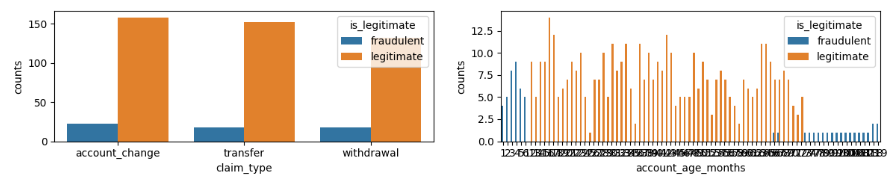

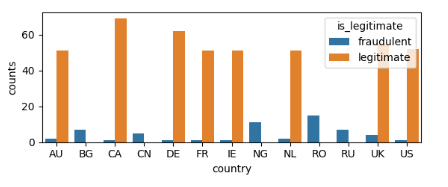

**Business Context Features - Geographic & Account Patterns**
1. **Geographic Fraud Concentration:**
  - Country Risk Analysis:
  - High-risk countries: NG, RO, RU, CN show significant fraud concentration (blue bars)
  - Low-risk countries: AU, CA, DE, FR, UK, US show legitimate dominance (orange bars)
  - Clear geographic clustering: Fraud concentrates in specific regions
  - Key insight: Country codes are powerful fraud predictors

2. **Claim Type Distribution :**
  - Account changes: Highest fraud proportion relative to volume
  - Transfers & Withdrawals: Lower but consistent fraud presence
  - Uniform pattern: Fraud attempts across all claim types
  - Key insight: Claim type provides moderate discrimination but fraud targets all services

3. **Account Age Pattern (Top Right):**
  - New accounts (0-12 months): High fraud concentration (blue spikes)
  - Older accounts (60+ months): Some fraud presence (compromised accounts)
  - Middle age (12-60 months): Predominantly legitimate activity
  - Key insight: Account age extremes indicate higher fraud risk

## Section 4: Pre-Correlation Analysis

In [ ]:
claimsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   claim_type                   500 non-null    object 
 1   claim_amount                 500 non-null    float64
 2   claim_timestamp              500 non-null    object 
 3   login_timestamp              500 non-null    object 
 4   account_age_months           500 non-null    int64  
 5   previous_claims_30d          500 non-null    int64  
 6   device_type                  500 non-null    object 
 7   browser                      500 non-null    object 
 8   operating_system             500 non-null    object 
 9   device_fingerprint           500 non-null    object 
 10  is_new_device                500 non-null    bool   
 11  ip_address                   500 non-null    object 
 12  country                      500 non-null    object 
 13  multiple_ips_same_da

In [ ]:
df_processedclaimsData = claimsData.copy()

In [ ]:
# Convert datetime columns
print("Converting datetime columns...")
df_processedclaimsData['claim_timestamp'] = pd.to_datetime(df_processedclaimsData['claim_timestamp'])
df_processedclaimsData['login_timestamp'] = pd.to_datetime(df_processedclaimsData['login_timestamp'])

# Extract datetime features
print("Extracting datetime features...")
df_processedclaimsData['claim_hour'] = df_processedclaimsData['claim_timestamp'].dt.hour
df_processedclaimsData['claim_day_of_week'] = df_processedclaimsData['claim_timestamp'].dt.dayofweek
df_processedclaimsData['claim_month'] = df_processedclaimsData['claim_timestamp'].dt.month
df_processedclaimsData['login_hour'] = df_processedclaimsData['login_timestamp'].dt.hour
df_processedclaimsData['login_day_of_week'] = df_processedclaimsData['login_timestamp'].dt.dayofweek

# Calculate time difference between login and claim
df_processedclaimsData['login_to_claim_hours'] = (
    df_processedclaimsData['claim_timestamp'] - df_processedclaimsData['login_timestamp']
).dt.total_seconds() / 3600


Converting datetime columns...
Extracting datetime features...


In [ ]:
# Handle boolean columns (convert True/False to 1/0)
boolean_columns = ['is_new_device', 'is_unusual_hours', 'is_weekend',
                   'impossible_travel', 'email_verified', 'phone_verified', 'two_fa_enabled']
print(f"Converting boolean columns: {boolean_columns}")
for col in boolean_columns:
    if col in df_processedclaimsData.columns:
        df_processedclaimsData[col] = df_processedclaimsData[col].astype(int)

Converting boolean columns: ['is_new_device', 'is_unusual_hours', 'is_weekend', 'impossible_travel', 'email_verified', 'phone_verified', 'two_fa_enabled']


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
categorical_columns = ['claim_type', 'device_type', 'browser', 'operating_system', 'country']
print(f"Encoding categorical columns: {categorical_columns}")

for col in categorical_columns:
    if col in df_processedclaimsData.columns:
        le = LabelEncoder()
        df_processedclaimsData[f'{col}_encoded'] = le.fit_transform(df_processedclaimsData[col])
        print(f"  {col}: {len(le.classes_)} unique values")

Encoding categorical columns: ['claim_type', 'device_type', 'browser', 'operating_system', 'country']
  claim_type: 3 unique values
  device_type: 3 unique values
  browser: 5 unique values
  operating_system: 5 unique values
  country: 13 unique values


In [ ]:
# Encode target variable
print("Encoding target variable...")
label_encoder_target = LabelEncoder()
df_processedclaimsData['is_legitimate_encoded'] = label_encoder_target.fit_transform(df_processedclaimsData['is_legitimate'])
print(f"Target encoding: {dict(zip(label_encoder_target.classes_, label_encoder_target.transform(label_encoder_target.classes_)))}")


Encoding target variable...
Target encoding: {'fraudulent': np.int64(0), 'legitimate': np.int64(1)}


In [ ]:
#Device fingerprint - create a feature for device fingerprint frequency
device_fp_counts = df_processedclaimsData['device_fingerprint'].value_counts()
df_processedclaimsData['device_fingerprint_frequency'] = df_processedclaimsData['device_fingerprint'].map(device_fp_counts)
df_processedclaimsData['is_unique_device_fingerprint'] = (df_processedclaimsData['device_fingerprint_frequency'] == 1).astype(int)

In [ ]:
# IP address - create features
ip_counts = df_processedclaimsData['ip_address'].value_counts()
df_processedclaimsData['ip_frequency'] = df_processedclaimsData['ip_address'].map(ip_counts)
df_processedclaimsData['is_unique_ip'] = (df_processedclaimsData['ip_frequency'] == 1).astype(int)

In [ ]:
df_processedclaimsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   claim_type                    500 non-null    object        
 1   claim_amount                  500 non-null    float64       
 2   claim_timestamp               500 non-null    datetime64[ns]
 3   login_timestamp               500 non-null    datetime64[ns]
 4   account_age_months            500 non-null    int64         
 5   previous_claims_30d           500 non-null    int64         
 6   device_type                   500 non-null    object        
 7   browser                       500 non-null    object        
 8   operating_system              500 non-null    object        
 9   device_fingerprint            500 non-null    object        
 10  is_new_device                 500 non-null    int64         
 11  ip_address                    50

In [ ]:
# Select numerical features for correlation matrix
correlation_features = [
    # Numerical features
    'claim_amount', 'account_age_months', #'previous_claims_30d', #'multiple_ips_same_day',
    #'failed_login_attempts',
    'session_duration_min', 'distance_from_last_login_km',
    'travel_velocity_kmh', #'user_agent_anomaly_score', #'risk_score',

    # Boolean features (already converted to int)
    'is_new_device', 'is_unusual_hours', 'is_weekend', #'impossible_travel',
    'email_verified', 'phone_verified', 'two_fa_enabled',

    # Encoded categorical features
    'claim_type_encoded', 'device_type_encoded', 'browser_encoded',
    'operating_system_encoded', 'country_encoded',

    # Datetime features
    'claim_hour', 'claim_day_of_week', 'claim_month', 'login_hour',
    'login_day_of_week',
    #'login_to_claim_hours',

    # High-cardinality derived features
    #'device_fingerprint_frequency',
    #'is_unique_device_fingerprint',
    #'ip_frequency',
    #'is_unique_ip',

    # Target variable
    'is_legitimate_encoded'
]

df_correlation = df_processedclaimsData[correlation_features].copy()

In [ ]:
# Handle any remaining missing values
print("Handling missing values...")
print(f"Missing values before cleaning: {df_correlation.isnull().sum().sum()}")
df_correlation = df_correlation.dropna()
print(f"Dataset shape after cleaning: {df_correlation.shape}")

Handling missing values...
Missing values before cleaning: 0
Dataset shape after cleaning: (500, 22)


In [ ]:
# ===================================================================
# PART 3: CORRELATION MATRIX ANALYSIS
# ===================================================================

print("\n\n3. CORRELATION MATRIX ANALYSIS")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = df_correlation.corr()
# Find high correlations with target variable
target_correlations = correlation_matrix['is_legitimate_encoded'].abs().sort_values(ascending=False)
print("Top features correlated with fraud label:")
print(target_correlations.head(10))




3. CORRELATION MATRIX ANALYSIS
Top features correlated with fraud label:
is_legitimate_encoded          1.000000
email_verified                 0.596790
session_duration_min           0.543641
is_new_device                  0.511335
distance_from_last_login_km    0.510519
claim_amount                   0.507034
phone_verified                 0.418000
two_fa_enabled                 0.373800
travel_velocity_kmh            0.340041
login_day_of_week              0.103777
Name: is_legitimate_encoded, dtype: float64


In [ ]:
# Find highly correlated feature pairs (potential multicollinearity)
print("\nHighly correlated feature pairs (|correlation| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")



Highly correlated feature pairs (|correlation| > 0.7):
  claim_day_of_week <-> login_day_of_week: 0.990
  claim_hour <-> login_hour: 0.907
  is_weekend <-> claim_day_of_week: 0.811
  is_weekend <-> login_day_of_week: 0.809




4. CREATING VISUALIZATIONS


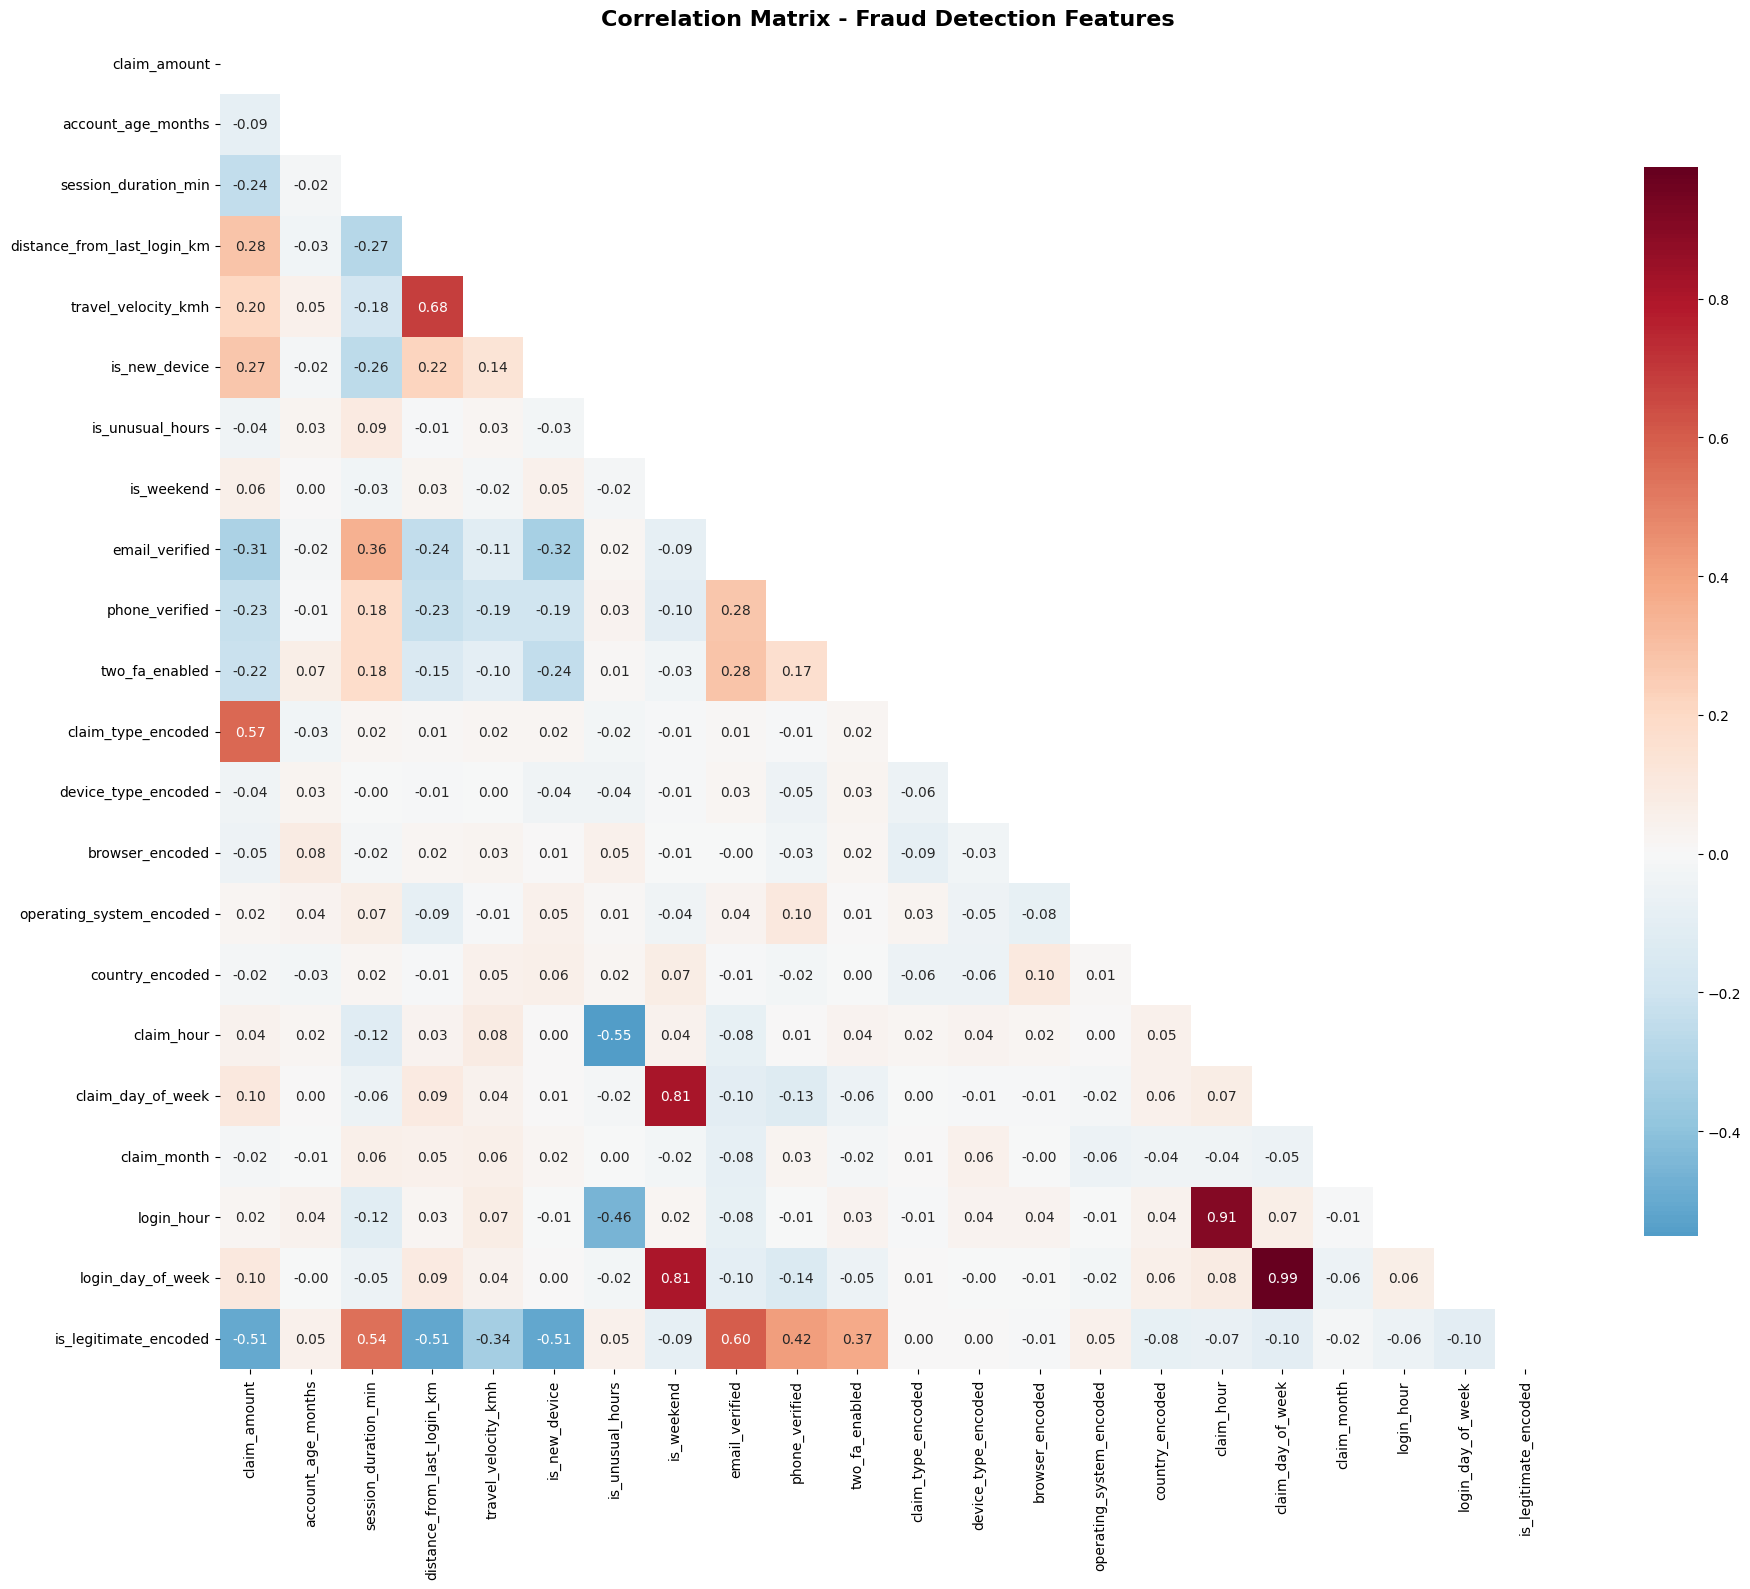

In [ ]:
# ===================================================================
# PART 4: VISUALIZATION
# ===================================================================

print("\n\n4. CREATING VISUALIZATIONS")
print("=" * 50)

# Create correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
           mask=mask,
           annot=True,
           cmap='RdBu_r',
           center=0,
           square=True,
           fmt='.2f',
           cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Fraud Detection Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

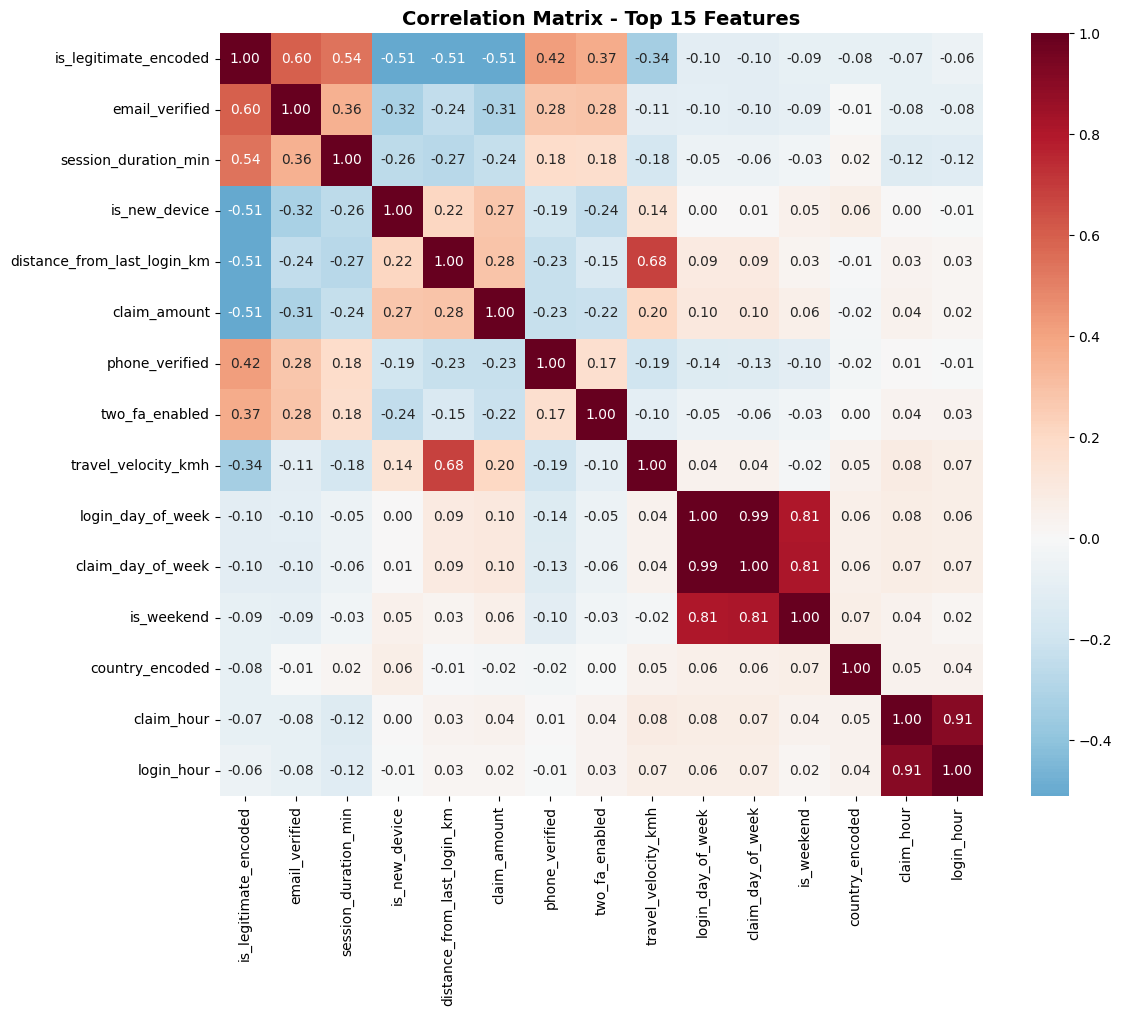

In [ ]:
# Create focused heatmap for top correlated features with target
top_features = target_correlations.head(15).index.tolist()
plt.figure(figsize=(12, 10))
top_corr_matrix = df_correlation[top_features].corr()
sns.heatmap(top_corr_matrix,
           annot=True,
           cmap='RdBu_r',
           center=0,
           square=True,
           fmt='.2f')
plt.title('Correlation Matrix - Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

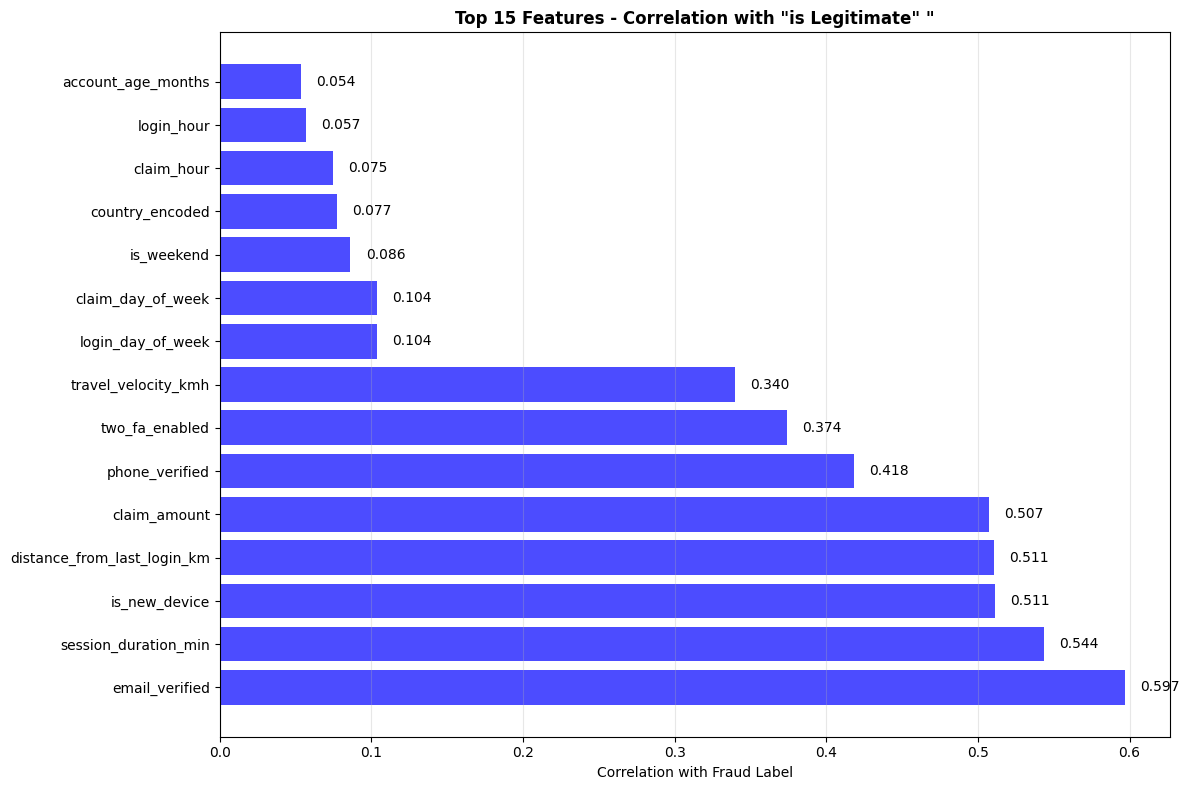

In [ ]:
# Feature importance visualization
plt.figure(figsize=(12, 8))
feature_importance = target_correlations.drop('is_legitimate_encoded').head(15)
colors = ['red' if x < 0 else 'blue' for x in feature_importance.values]
bars = plt.barh(range(len(feature_importance)), feature_importance.values, color=colors, alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance.index)
plt.xlabel('Correlation with Fraud Label')
plt.title('Top 15 Features - Correlation with "is Legitimate" "', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, feature_importance.values)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}',
             va='center', ha='left' if val > 0 else 'right')
plt.tight_layout()
plt.show()

In [ ]:
# Additional imports for feature selection
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, mutual_info_classif,
    RFE, RFECV, SelectFromModel, VarianceThreshold
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🎯 STARTING FEATURE SELECTION PIPELINE")
print("="*60)
print(f"Starting with {X.shape[1]} features")

# Store original features for comparison
X_original = X.copy()


🎯 STARTING FEATURE SELECTION PIPELINE
Starting with 21 features


In [ ]:
# =============================================================================
# 1. REMOVE LOW VARIANCE FEATURES
# =============================================================================

print(f"\n📊 STEP 1: REMOVING LOW VARIANCE FEATURES")
print("="*50)

# Set variance threshold
variance_threshold = 0.01

# Apply variance threshold
variance_selector = VarianceThreshold(threshold=variance_threshold)
X_variance_filtered = variance_selector.fit_transform(X)

# Get selected feature names
variance_selected_features = X.columns[variance_selector.get_support()].tolist()
variance_removed_features = X.columns[~variance_selector.get_support()].tolist()

print(f"Variance threshold: {variance_threshold}")
print(f"Removed {len(variance_removed_features)} low-variance features:")
for feat in variance_removed_features[:10]:  # Show first 10
    print(f"  • {feat}")

if len(variance_removed_features) > 10:
    print(f"  ... and {len(variance_removed_features) - 10} more")

print(f"✅ Features after variance filtering: {len(variance_selected_features)} (removed {len(variance_removed_features)})")

# Update X with variance-filtered features
X_step1 = pd.DataFrame(X_variance_filtered, columns=variance_selected_features, index=X.index)


📊 STEP 1: REMOVING LOW VARIANCE FEATURES
Variance threshold: 0.01
Removed 0 low-variance features:
✅ Features after variance filtering: 21 (removed 0)


In [ ]:
# =============================================================================
# 2. REMOVE HIGHLY CORRELATED FEATURES
# =============================================================================

print(f"\n🔗 STEP 2: REMOVING HIGHLY CORRELATED FEATURES")
print("="*50)

# Set correlation threshold
correlation_threshold = 0.95

# Calculate correlation matrix for numerical features only
numerical_cols_for_corr = X_step1.select_dtypes(include=[np.number]).columns
X_numerical = X_step1[numerical_cols_for_corr]

if len(numerical_cols_for_corr) > 1:
    # Calculate correlation matrix
    corr_matrix = X_numerical.corr().abs()

    # Find highly correlated feature pairs
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find features to drop
    correlation_features_to_drop = [column for column in upper_triangle.columns
                                   if any(upper_triangle[column] > correlation_threshold)]

    print(f"Correlation threshold: {correlation_threshold}")
    print(f"Found {len(correlation_features_to_drop)} highly correlated features to remove:")
    for feat in correlation_features_to_drop[:10]:  # Show first 10
        print(f"  • {feat}")

    if len(correlation_features_to_drop) > 10:
        print(f"  ... and {len(correlation_features_to_drop) - 10} more")

    # Remove highly correlated features
    X_step2 = X_step1.drop(correlation_features_to_drop, axis=1)

    print(f"✅ Features after correlation filtering: {X_step2.shape[1]} (removed {len(correlation_features_to_drop)})")
else:
    print("Not enough numerical features for correlation analysis")
    X_step2 = X_step1.copy()
    correlation_features_to_drop = []


🔗 STEP 2: REMOVING HIGHLY CORRELATED FEATURES
Correlation threshold: 0.95
Found 1 highly correlated features to remove:
  • login_day_of_week
✅ Features after correlation filtering: 20 (removed 1)


In [ ]:
df_correlation.head()

,claim_amount,account_age_months,session_duration_min,distance_from_last_login_km,travel_velocity_kmh,is_new_device,is_unusual_hours,is_weekend,email_verified,phone_verified,two_fa_enabled,claim_type_encoded,device_type_encoded,browser_encoded,operating_system_encoded,country_encoded,claim_hour,claim_day_of_week,claim_month,login_hour,login_day_of_week,is_legitimate_encoded
0,11310.60,20,45.07,358.01,26.15,0,0,0,1,1,0,2,2,0,1,0,7,0,10,6,0,1
1,11507.95,25,28.93,486.56,37.14,0,0,0,1,1,0,1,0,1,2,4,8,4,12,8,4,1
2,14793.10,30,44.18,350.91,21.60,0,0,0,1,1,1,2,0,1,3,2,7,4,11,6,4,1
3,0.00,55,54.23,249.62,45.41,0,0,0,1,1,0,0,0,2,2,12,17,3,12,16,3,1
4,11969.25,26,39.79,192.38,13.25,0,0,0,1,1,0,1,1,0,2,2,12,1,8,11,1,1


In [ ]:
# =============================================================================
# 3. UNIVARIATE STATISTICAL FEATURE SELECTION
# =============================================================================

print(f"\n📈 STEP 3: UNIVARIATE STATISTICAL FEATURE SELECTION")
print("="*50)

from sklearn.preprocessing import LabelEncoder
y = df_correlation['is_legitimate_encoded']  # or df_eng['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Set number of features to select
k_univariate = min(30, X_step2.shape[1])  # Select up to 30 features

# Apply SelectKBest with f_classif
univariate_selector = SelectKBest(score_func=f_classif, k=k_univariate)
X_univariate_selected = univariate_selector.fit_transform(X_step2, y_encoded)

# Get feature scores and selected features
univariate_scores = univariate_selector.scores_
univariate_selected_features = X_step2.columns[univariate_selector.get_support()].tolist()

# Create feature scores dataframe
univariate_feature_scores = pd.DataFrame({
    'Feature': X_step2.columns,
    'Score': univariate_scores,
    'Selected': univariate_selector.get_support()
}).sort_values('Score', ascending=False)

print(f"Selecting top {k_univariate} features by F-statistic")
print(f"🏆 TOP {min(15, k_univariate)} FEATURES BY STATISTICAL SCORE:")
for i, (_, row) in enumerate(univariate_feature_scores.head(15).iterrows(), 1):
    selected_marker = "✓" if row['Selected'] else " "
    print(f"  {selected_marker} {i:2d}. {row['Feature']:<30} (score: {row['Score']:.4f})")

# Create DataFrame with selected features
X_univariate = pd.DataFrame(X_univariate_selected, columns=univariate_selected_features, index=X_step2.index)

print(f"✅ Univariate selection: {len(univariate_selected_features)} features selected")


📈 STEP 3: UNIVARIATE STATISTICAL FEATURE SELECTION
Selecting top 20 features by F-statistic
🏆 TOP 15 FEATURES BY STATISTICAL SCORE:
  ✓  1. email_verified                 (score: 275.4825)
  ✓  2. session_duration_min           (score: 208.9298)
  ✓  3. is_new_device                  (score: 176.3061)
  ✓  4. distance_from_last_login_km    (score: 175.5461)
  ✓  5. claim_amount                   (score: 172.3307)
  ✓  6. phone_verified                 (score: 105.4347)
  ✓  7. two_fa_enabled                 (score: 80.8855)
  ✓  8. travel_velocity_kmh            (score: 65.1114)
  ✓  9. claim_day_of_week              (score: 5.3982)
  ✓ 10. is_weekend                     (score: 3.7302)
  ✓ 11. country_encoded                (score: 2.9988)
  ✓ 12. claim_hour                     (score: 2.8114)
  ✓ 13. login_hour                     (score: 1.6171)
  ✓ 14. account_age_months             (score: 1.4360)
  ✓ 15. operating_system_encoded       (score: 1.2659)
✅ Univariate selection: 20 f


🌳 STEP 4: TREE-BASED FEATURE IMPORTANCE SELECTION
Training Random Forest for feature importance...
🏆 TOP 15 FEATURES BY TREE IMPORTANCE:
  ✓  1. session_duration_min           (importance: 0.2631)
  ✓  2. account_age_months             (importance: 0.2459)
  ✓  3. claim_amount                   (importance: 0.1722)
  ✓  4. email_verified                 (importance: 0.0673)
  ✓  5. distance_from_last_login_km    (importance: 0.0657)
  ✓  6. is_new_device                  (importance: 0.0516)
  ✓  7. travel_velocity_kmh            (importance: 0.0465)
  ✓  8. phone_verified                 (importance: 0.0248)
  ✓  9. two_fa_enabled                 (importance: 0.0146)
  ✓ 10. country_encoded                (importance: 0.0131)
  ✓ 11. login_hour                     (importance: 0.0072)
  ✓ 12. claim_month                    (importance: 0.0063)
  ✓ 13. claim_hour                     (importance: 0.0057)
  ✓ 14. operating_system_encoded       (importance: 0.0041)
  ✓ 15. claim_day_of_w

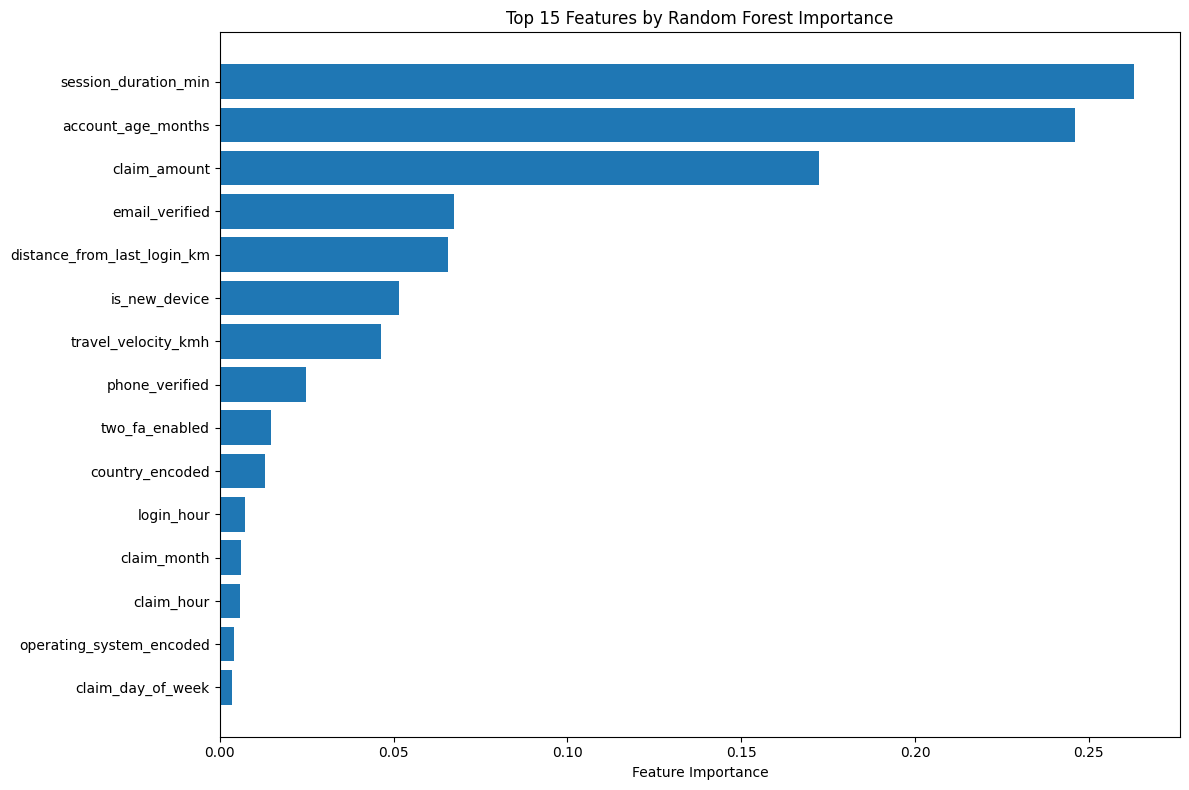

In [ ]:
# =============================================================================
# 4. TREE-BASED FEATURE IMPORTANCE SELECTION
# =============================================================================

print(f"\n🌳 STEP 4: TREE-BASED FEATURE IMPORTANCE SELECTION")
print("="*50)

# Set number of features to select
n_tree_features = min(30, X_step2.shape[1])

# Train Random Forest for feature importance
print("Training Random Forest for feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_step2, y_encoded)

# Get feature importance
tree_feature_importance = pd.DataFrame({
    'Feature': X_step2.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

# Select top features
tree_top_features = tree_feature_importance.head(n_tree_features)['Feature'].tolist()

print(f"🏆 TOP {min(15, n_tree_features)} FEATURES BY TREE IMPORTANCE:")
for i, (_, row) in enumerate(tree_feature_importance.head(15).iterrows(), 1):
    selected_marker = "✓" if row['Feature'] in tree_top_features else " "
    print(f"  {selected_marker} {i:2d}. {row['Feature']:<30} (importance: {row['Importance']:.4f})")

# Create DataFrame with selected features
X_tree = X_step2[tree_top_features]

print(f"✅ Tree-based selection: {len(tree_top_features)} features selected")

# Create visualization
plt.figure(figsize=(12, 8))
top_15_tree = tree_feature_importance.head(15)
plt.barh(range(len(top_15_tree)), top_15_tree['Importance'])
plt.yticks(range(len(top_15_tree)), top_15_tree['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Random Forest Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 5. RECURSIVE FEATURE ELIMINATION (RFE)
# =============================================================================

print(f"\n🔄 STEP 5: RECURSIVE FEATURE ELIMINATION")
print("="*50)

# Set number of features for RFE
n_rfe_features = min(25, X_step2.shape[1])

print(f"Finding optimal number of features with cross-validation...")

# Use RFECV for automatic feature number selection
rfe_estimator = LogisticRegression(random_state=42, max_iter=1000)
rfecv_selector = RFECV(estimator=rfe_estimator, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv_selector.fit(X_step2, y_encoded)

optimal_n_features = rfecv_selector.n_features_
print(f"✅ Optimal number of features by CV: {optimal_n_features}")

# Use RFE with target number of features
print(f"Selecting exactly {n_rfe_features} features using RFE...")
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=n_rfe_features)
rfe_selector.fit(X_step2, y_encoded)

rfe_selected_features = X_step2.columns[rfe_selector.support_].tolist()

# Feature ranking
rfe_feature_ranking = pd.DataFrame({
    'Feature': X_step2.columns,
    'Ranking': rfe_selector.ranking_,
    'Selected': rfe_selector.support_
}).sort_values('Ranking')

print(f"🏆 TOP {n_rfe_features} FEATURES BY RFE (ranking = 1):")
rfe_selected_df = rfe_feature_ranking[rfe_feature_ranking['Selected'] == True]
for i, (_, row) in enumerate(rfe_selected_df.iterrows(), 1):
    print(f"  ✓ {i:2d}. {row['Feature']}")

# Create DataFrame with selected features
X_rfe = X_step2[rfe_selected_features]

print(f"✅ RFE selection: {len(rfe_selected_features)} features selected")

# Plot cross-validation scores if available
if hasattr(rfecv_selector, 'grid_scores_'):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rfecv_selector.grid_scores_) + 1), rfecv_selector.grid_scores_)
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (ROC-AUC)')
    plt.title('Recursive Feature Elimination - CV Scores')
    plt.axvline(x=optimal_n_features, color='red', linestyle='--',
               label=f'Optimal: {optimal_n_features} features')
    plt.legend()
    plt.grid(True)
    plt.show()


🔄 STEP 5: RECURSIVE FEATURE ELIMINATION
Finding optimal number of features with cross-validation...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

✅ Optimal number of features by CV: 19
Selecting exactly 20 features using RFE...
🏆 TOP 20 FEATURES BY RFE (ranking = 1):
  ✓  1. claim_amount
  ✓  2. account_age_months
  ✓  3. session_duration_min
  ✓  4. distance_from_last_login_km
  ✓  5. travel_velocity_kmh
  ✓  6. is_new_device
  ✓  7. is_unusual_hours
  ✓  8. is_weekend
  ✓  9. email_verified
  ✓ 10. phone_verified
  ✓ 11. two_fa_enabled
  ✓ 12. claim_type_encoded
  ✓ 13. device_type_encoded
  ✓ 14. browser_encoded
  ✓ 15. operating_system_encoded
  ✓ 16. country_encoded
  ✓ 17. claim_hour
  ✓ 18. claim_day_of_week
  ✓ 19. claim_month
  ✓ 20. login_hour
✅ RFE selection: 20 features selected


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# =============================================================================
# 6. LASSO-BASED FEATURE SELECTION
# =============================================================================

print(f"\n🎯 STEP 6: LASSO-BASED FEATURE SELECTION")
print("="*50)

# Use LassoCV to find optimal alpha
print("Finding optimal regularization strength...")
lasso_selector = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso_selector.fit(X_step2, y_encoded)

# Get selected features (non-zero coefficients)
lasso_selected_features = X_step2.columns[lasso_selector.coef_ != 0].tolist()

# Feature coefficients
lasso_feature_coefs = pd.DataFrame({
    'Feature': X_step2.columns,
    'Coefficient': lasso_selector.coef_,
    'Selected': lasso_selector.coef_ != 0
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"✅ Optimal alpha: {lasso_selector.alpha_:.6f}")
print(f"✅ Selected {len(lasso_selected_features)} features out of {X_step2.shape[1]}")

print(f"🏆 TOP FEATURES BY LASSO COEFFICIENTS:")
lasso_selected_df = lasso_feature_coefs[lasso_feature_coefs['Selected'] == True]
for i, (_, row) in enumerate(lasso_selected_df.head(20).iterrows(), 1):
    print(f"  ✓ {i:2d}. {row['Feature']:<30} (coef: {row['Coefficient']:8.4f})")

# Create DataFrame with selected features
X_lasso = X_step2[lasso_selected_features]

print(f"✅ Lasso selection: {len(lasso_selected_features)} features selected")



🎯 STEP 6: LASSO-BASED FEATURE SELECTION
Finding optimal regularization strength...
✅ Optimal alpha: 1.265309
✅ Selected 3 features out of 20
🏆 TOP FEATURES BY LASSO COEFFICIENTS:
  ✓  1. session_duration_min           (coef:   0.0021)
  ✓  2. distance_from_last_login_km    (coef:  -0.0001)
  ✓  3. claim_amount                   (coef:  -0.0000)
✅ Lasso selection: 3 features selected


In [ ]:
# =============================================================================
# 7. MUTUAL INFORMATION FEATURE SELECTION
# =============================================================================

print(f"\n🔄 STEP 7: MUTUAL INFORMATION FEATURE SELECTION")
print("="*50)

# Set number of features to select
k_mutual_info = min(25, X_step2.shape[1])

# Calculate mutual information scores
print("Calculating mutual information scores...")
mi_scores = mutual_info_classif(X_step2, y_encoded, random_state=42)

# Create feature scores dataframe
mi_feature_scores = pd.DataFrame({
    'Feature': X_step2.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

# Select top k features
mi_top_features = mi_feature_scores.head(k_mutual_info)['Feature'].tolist()

print(f"🏆 TOP {min(15, k_mutual_info)} FEATURES BY MUTUAL INFORMATION:")
for i, (_, row) in enumerate(mi_feature_scores.head(15).iterrows(), 1):
    selected_marker = "✓" if row['Feature'] in mi_top_features else " "
    print(f"  {selected_marker} {i:2d}. {row['Feature']:<30} (MI score: {row['MI_Score']:.4f})")

# Create DataFrame with selected features
X_mutual_info = X_step2[mi_top_features]

print(f"✅ Mutual information selection: {len(mi_top_features)} features selected")


🔄 STEP 7: MUTUAL INFORMATION FEATURE SELECTION
Calculating mutual information scores...
🏆 TOP 15 FEATURES BY MUTUAL INFORMATION:
  ✓  1. account_age_months             (MI score: 0.3329)
  ✓  2. session_duration_min           (MI score: 0.2796)
  ✓  3. country_encoded                (MI score: 0.2567)
  ✓  4. claim_amount                   (MI score: 0.1852)
  ✓  5. is_new_device                  (MI score: 0.1276)
  ✓  6. email_verified                 (MI score: 0.1270)
  ✓  7. distance_from_last_login_km    (MI score: 0.0793)
  ✓  8. two_fa_enabled                 (MI score: 0.0630)
  ✓  9. phone_verified                 (MI score: 0.0612)
  ✓ 10. travel_velocity_kmh            (MI score: 0.0607)
  ✓ 11. is_weekend                     (MI score: 0.0220)
  ✓ 12. claim_day_of_week              (MI score: 0.0183)
  ✓ 13. is_unusual_hours               (MI score: 0.0164)
  ✓ 14. operating_system_encoded       (MI score: 0.0130)
  ✓ 15. claim_type_encoded             (MI score: 0.0000)


In [ ]:
# =============================================================================
# 8. FEATURE SELECTION CONSENSUS VOTING
# =============================================================================

print(f"\n🗳️ STEP 8: FEATURE SELECTION CONSENSUS VOTING")
print("="*50)

# Combine results using voting
tree_features_set = set(tree_top_features)
univariate_features_set = set(univariate_selected_features)
rfe_features_set = set(rfe_selected_features)
lasso_features_set = set(lasso_selected_features)
mi_features_set = set(mi_top_features)

# Get all features that were selected by any method
all_candidate_features = tree_features_set.union(univariate_features_set).union(rfe_features_set).union(lasso_features_set).union(mi_features_set)

# Count votes for each feature
feature_votes = {}
for feature in all_candidate_features:
    votes = 0
    methods = []
    if feature in tree_features_set:
        votes += 1
        methods.append("Tree")
    if feature in univariate_features_set:
        votes += 1
        methods.append("Univariate")
    if feature in rfe_features_set:
        votes += 1
        methods.append("RFE")
    if feature in lasso_features_set:
        votes += 1
        methods.append("Lasso")
    if feature in mi_features_set:
        votes += 1
        methods.append("MI")

    feature_votes[feature] = {
        'votes': votes,
        'methods': methods
    }

# Sort by votes
sorted_features_by_votes = sorted(feature_votes.items(), key=lambda x: x[1]['votes'], reverse=True)

print("🏆 FEATURE SELECTION CONSENSUS RANKING:")
print("   Feature                           Votes  Methods")
print("   " + "="*60)
for i, (feature, info) in enumerate(sorted_features_by_votes[:30], 1):
    methods_str = ", ".join(info['methods'])
    print(f"   {i:2d}. {feature:<30} {info['votes']}/5   {methods_str}")



🗳️ STEP 8: FEATURE SELECTION CONSENSUS VOTING
🏆 FEATURE SELECTION CONSENSUS RANKING:
   Feature                           Votes  Methods
    1. distance_from_last_login_km    5/5   Tree, Univariate, RFE, Lasso, MI
    2. session_duration_min           5/5   Tree, Univariate, RFE, Lasso, MI
    3. claim_amount                   5/5   Tree, Univariate, RFE, Lasso, MI
    4. claim_type_encoded             4/5   Tree, Univariate, RFE, MI
    5. phone_verified                 4/5   Tree, Univariate, RFE, MI
    6. browser_encoded                4/5   Tree, Univariate, RFE, MI
    7. travel_velocity_kmh            4/5   Tree, Univariate, RFE, MI
    8. account_age_months             4/5   Tree, Univariate, RFE, MI
    9. is_new_device                  4/5   Tree, Univariate, RFE, MI
   10. two_fa_enabled                 4/5   Tree, Univariate, RFE, MI
   11. device_type_encoded            4/5   Tree, Univariate, RFE, MI
   12. operating_system_encoded       4/5   Tree, Univariate, RFE, MI
 

In [ ]:
# =============================================================================
# 9. SELECT FINAL FEATURES BASED ON CONSENSUS
# =============================================================================

print(f"\n🎯 STEP 9: SELECTING FINAL FEATURES")
print("="*50)

# Set target number of final features
target_final_features = 25

# Select features with most votes
final_selected_features = [feature for feature, info in sorted_features_by_votes[:target_final_features]]

# Create final feature set
X_final_selected = X_step2[final_selected_features]

print(f"Target features: {target_final_features}")
print(f"✅ Final selected features: {len(final_selected_features)}")

print(f"\n🏆 FINAL {len(final_selected_features)} SELECTED FEATURES:")
for i, (feature, info) in enumerate(sorted_features_by_votes[:target_final_features], 1):
    print(f"  {i:2d}. {feature:<30} ({info['votes']}/5 votes)")


🎯 STEP 9: SELECTING FINAL FEATURES
Target features: 25
✅ Final selected features: 20

🏆 FINAL 20 SELECTED FEATURES:
   1. distance_from_last_login_km    (5/5 votes)
   2. session_duration_min           (5/5 votes)
   3. claim_amount                   (5/5 votes)
   4. claim_type_encoded             (4/5 votes)
   5. phone_verified                 (4/5 votes)
   6. browser_encoded                (4/5 votes)
   7. travel_velocity_kmh            (4/5 votes)
   8. account_age_months             (4/5 votes)
   9. is_new_device                  (4/5 votes)
  10. two_fa_enabled                 (4/5 votes)
  11. device_type_encoded            (4/5 votes)
  12. operating_system_encoded       (4/5 votes)
  13. login_hour                     (4/5 votes)
  14. is_weekend                     (4/5 votes)
  15. country_encoded                (4/5 votes)
  16. is_unusual_hours               (4/5 votes)
  17. claim_month                    (4/5 votes)
  18. email_verified                 (4/5 votes)
 

In [ ]:
# =============================================================================
# 10. FEATURE SELECTION SUMMARY
# =============================================================================

print(f"\n📊 FEATURE SELECTION SUMMARY")
print("="*50)

print(f"📈 FEATURE REDUCTION PIPELINE:")
print(f"  • Original features: {X_original.shape[1]}")
print(f"  • After variance filter: {X_step1.shape[1]} (-{len(variance_removed_features)})")
print(f"  • After correlation filter: {X_step2.shape[1]} (-{len(correlation_features_to_drop)})")
print(f"  • Final selected features: {len(final_selected_features)}")
print(f"  • Total reduction: {X_original.shape[1] - len(final_selected_features)} features")
print(f"  • Reduction percentage: {(X_original.shape[1] - len(final_selected_features))/X_original.shape[1]*100:.1f}%")

print(f"\n🔍 SELECTION METHOD BREAKDOWN:")
print(f"  • Tree-based selected: {len(tree_top_features)} features")
print(f"  • Univariate selected: {len(univariate_selected_features)} features")
print(f"  • RFE selected: {len(rfe_selected_features)} features")
print(f"  • Lasso selected: {len(lasso_selected_features)} features")
print(f"  • Mutual Info selected: {len(mi_top_features)} features")

# Vote distribution
vote_distribution = {}
for feature, info in feature_votes.items():
    votes = info['votes']
    if votes not in vote_distribution:
        vote_distribution[votes] = 0
    vote_distribution[votes] += 1

print(f"\n🗳️ VOTE DISTRIBUTION:")
for votes in sorted(vote_distribution.keys(), reverse=True):
    count = vote_distribution[votes]
    print(f"  • {votes}/5 votes: {count} features")

# =============================================================================
# 11. EVALUATE FEATURE SELECTION IMPACT
# =============================================================================

print(f"\n📊 EVALUATING FEATURE SELECTION IMPACT")
print("="*50)

# Compare original vs selected features
evaluation_results = {}

# Test both original and selected features
for name, X_data in [("Original", X_original), ("Selected", X_final_selected)]:
    print(f"\n{name} Feature Set: {X_data.shape[1]} features")

    # Split data for evaluation
    X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(
        X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Train simple logistic regression for comparison
    eval_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    eval_model.fit(X_eval_train, y_eval_train)

    # Calculate metrics
    train_accuracy = eval_model.score(X_eval_train, y_eval_train)
    test_accuracy = eval_model.score(X_eval_test, y_eval_test)
    overfitting = train_accuracy - test_accuracy

    # Store results
    evaluation_results[name] = {
        'features': X_data.shape[1],
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'overfitting': overfitting
    }

    print(f"  • Features: {X_data.shape[1]}")
    print(f"  • Train Accuracy: {train_accuracy:.4f}")
    print(f"  • Test Accuracy: {test_accuracy:.4f}")
    print(f"  • Overfitting: {overfitting:.4f}")

# Comparison summary
print(f"\n📈 FEATURE SELECTION IMPACT ANALYSIS:")
orig_results = evaluation_results["Original"]
sel_results = evaluation_results["Selected"]

feature_reduction_pct = (orig_results['features'] - sel_results['features']) / orig_results['features'] * 100
accuracy_change = sel_results['test_accuracy'] - orig_results['test_accuracy']
overfitting_change = sel_results['overfitting'] - orig_results['overfitting']

print(f"  • Feature Reduction: {orig_results['features']} → {sel_results['features']} ({feature_reduction_pct:.1f}% reduction)")
print(f"  • Test Accuracy Change: {orig_results['test_accuracy']:.4f} → {sel_results['test_accuracy']:.4f} ({accuracy_change:+.4f})")
print(f"  • Overfitting Change: {orig_results['overfitting']:.4f} → {sel_results['overfitting']:.4f} ({overfitting_change:+.4f})")

# Interpretation
if accuracy_change > 0.01:
    print("  ✅ Feature selection SIGNIFICANTLY IMPROVED model performance!")
elif accuracy_change > 0:
    print("  ✅ Feature selection slightly improved model performance!")
elif abs(accuracy_change) < 0.01:
    print("  ✅ Feature selection maintained performance with fewer features!")
else:
    print("  ⚠️ Feature selection reduced performance - consider keeping more features")

if overfitting_change < -0.01:
    print("  ✅ Feature selection SIGNIFICANTLY REDUCED overfitting!")
elif overfitting_change < 0:
    print("  ✅ Feature selection reduced overfitting!")


📊 FEATURE SELECTION SUMMARY
📈 FEATURE REDUCTION PIPELINE:
  • Original features: 21
  • After variance filter: 21 (-0)
  • After correlation filter: 20 (-1)
  • Final selected features: 20
  • Total reduction: 1 features
  • Reduction percentage: 4.8%

🔍 SELECTION METHOD BREAKDOWN:
  • Tree-based selected: 20 features
  • Univariate selected: 20 features
  • RFE selected: 20 features
  • Lasso selected: 3 features
  • Mutual Info selected: 20 features

🗳️ VOTE DISTRIBUTION:
  • 5/5 votes: 3 features
  • 4/5 votes: 17 features

📊 EVALUATING FEATURE SELECTION IMPACT

Original Feature Set: 21 features


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  • Features: 21
  • Train Accuracy: 0.9950
  • Test Accuracy: 1.0000
  • Overfitting: -0.0050

Selected Feature Set: 20 features
  • Features: 20
  • Train Accuracy: 0.9975
  • Test Accuracy: 1.0000
  • Overfitting: -0.0025

📈 FEATURE SELECTION IMPACT ANALYSIS:
  • Feature Reduction: 21 → 20 (4.8% reduction)
  • Test Accuracy Change: 1.0000 → 1.0000 (+0.0000)
  • Overfitting Change: -0.0050 → -0.0025 (+0.0025)
  ✅ Feature selection maintained performance with fewer features!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# =============================================================================
# 12. UPDATE DATASET FOR PIPELINE CONTINUATION
# =============================================================================

print(f"\n🔄 UPDATING DATASET FOR PIPELINE CONTINUATION")
print("="*50)

# Replace X with selected features for the rest of the pipeline
X = X_final_selected.copy()

print(f"✅ Dataset updated with {X.shape[1]} selected features")
print(f"✅ Ready to continue with train/test split and model training")

# Store feature selection information for later use
feature_selection_info = {
    'original_features': list(X_original.columns),
    'selected_features': final_selected_features,
    'feature_votes': feature_votes,
    'tree_importance': tree_feature_importance,
    'univariate_scores': univariate_feature_scores,
    'rfe_ranking': rfe_feature_ranking,
    'lasso_coefficients': lasso_feature_coefs,
    'mi_scores': mi_feature_scores,
    'evaluation_results': evaluation_results
}

print(f"\n🏆 TOP 10 FINAL SELECTED FEATURES:")
for i, feature in enumerate(final_selected_features[:10], 1):
    votes = feature_votes[feature]['votes']
    methods = ", ".join(feature_votes[feature]['methods'])
    print(f"  {i:2d}. {feature:<30} ({votes}/5 votes: {methods})")

print(f"\n🎉 FEATURE SELECTION COMPLETED!")
print(f"📊 Reduced from {X_original.shape[1]} to {X.shape[1]} features ({feature_reduction_pct:.1f}% reduction)")
print(f"🚀 Continue with your existing pipeline using the selected features")


🔄 UPDATING DATASET FOR PIPELINE CONTINUATION
✅ Dataset updated with 20 selected features
✅ Ready to continue with train/test split and model training

🏆 TOP 10 FINAL SELECTED FEATURES:
   1. distance_from_last_login_km    (5/5 votes: Tree, Univariate, RFE, Lasso, MI)
   2. session_duration_min           (5/5 votes: Tree, Univariate, RFE, Lasso, MI)
   3. claim_amount                   (5/5 votes: Tree, Univariate, RFE, Lasso, MI)
   4. claim_type_encoded             (4/5 votes: Tree, Univariate, RFE, MI)
   5. phone_verified                 (4/5 votes: Tree, Univariate, RFE, MI)
   6. browser_encoded                (4/5 votes: Tree, Univariate, RFE, MI)
   7. travel_velocity_kmh            (4/5 votes: Tree, Univariate, RFE, MI)
   8. account_age_months             (4/5 votes: Tree, Univariate, RFE, MI)
   9. is_new_device                  (4/5 votes: Tree, Univariate, RFE, MI)
  10. two_fa_enabled                 (4/5 votes: Tree, Univariate, RFE, MI)

🎉 FEATURE SELECTION COMPLETED!
📊



5. PREPARING DATA FOR LOGISTIC REGRESSION
🎯 Using features selected from feature selection pipeline
Selected features: 20
Feature matrix shape: (500, 20)
Target vector shape: (500,)
Class distribution: [ 58 442]

🔄 DATA SPLITTING AND PREPROCESSING
Training set shape: (400, 20)
Test set shape: (100, 20)


6. LOGISTIC REGRESSION MODEL
MODEL PERFORMANCE:
Training Accuracy: 0.9900
Test Accuracy: 0.9900
ROC AUC Score: 0.9972

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.99      1.00      0.99        88

    accuracy                           0.99       100
   macro avg       0.99      0.96      0.98       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[11  1]
 [ 0 88]]

Top 10 Most Important Features (by coefficient magnitude):
                        feature  coefficient
1          session_duration_min     0.973765
8                 is_new_device    

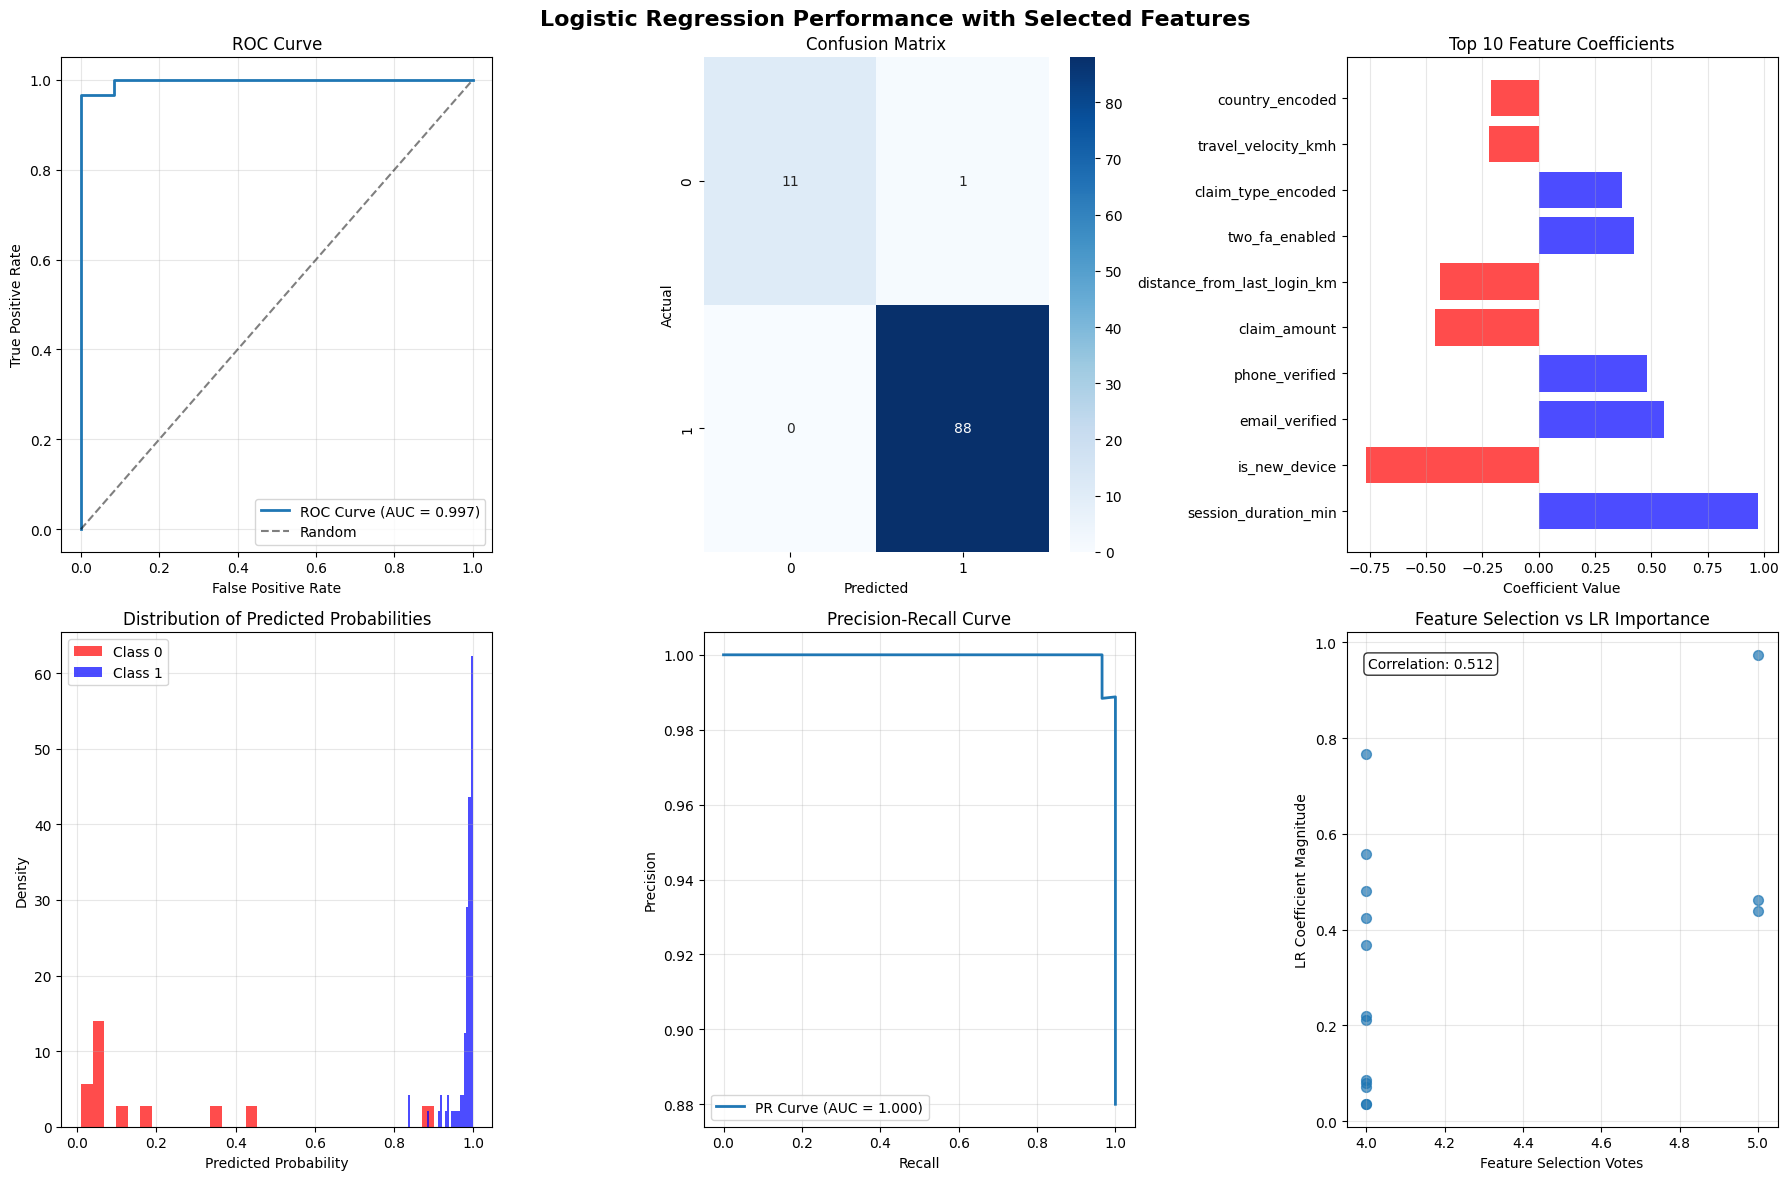

In [ ]:
# ===================================================================
# PART 5: PREPARE DATA FOR LOGISTIC REGRESSION
# ===================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n\n5. PREPARING DATA FOR LOGISTIC REGRESSION")
print("=" * 50)

# Use the selected features from the feature selection pipeline
print("🎯 Using features selected from feature selection pipeline")
print(f"Selected features: {len(final_selected_features)}")

# Use X (already updated with selected features) and y_encoded from feature selection
X_selected = X.copy()  # X was already updated in feature selection
y_selected = y_encoded.copy()  # y_encoded from feature selection

print(f"Feature matrix shape: {X_selected.shape}")
print(f"Target vector shape: {y_selected.shape}")
print(f"Class distribution: {np.bincount(y_selected)}")

print(f"\n🔄 DATA SPLITTING AND PREPROCESSING")
print("=" * 40)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42, stratify=y_selected
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Prepare features and target
# X = df_correlation.drop('is_legitimate_encoded', axis=1)
# y = df_correlation['is_legitimate_encoded']

# print(f"Feature matrix shape: {X.shape}")
# print(f"Target vector shape: {y.shape}")
# print(f"Class distribution: {y.value_counts().values}")

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# ===================================================================
# PART 6: LOGISTIC REGRESSION MODEL
# ===================================================================

print("\n\n6. LOGISTIC REGRESSION MODEL")
print("=" * 50)

# Train logistic regression model
#lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model = LogisticRegression(penalty='l2', C=0.1)  # Ridge)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Model evaluation
print("MODEL PERFORMANCE:")
print("=" * 30)
print(f"Training Accuracy: {lr_model.score(X_train_scaled, y_train):.4f}")
print(f"Test Accuracy: {lr_model.score(X_test_scaled, y_test):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance from logistic regression coefficients
feature_importance_lr = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features (by coefficient magnitude):")
print(feature_importance_lr.head(10)[['feature', 'coefficient']])


# ===================================================================
# COMPARISON WITH FEATURE SELECTION RESULTS
# ===================================================================

print(f"\n📊 FEATURE SELECTION VS LOGISTIC REGRESSION IMPORTANCE")
print("=" * 55)

# Compare feature selection votes with logistic regression coefficients
if 'feature_votes' in locals():
    comparison_df = pd.DataFrame({
        'feature': feature_importance_lr['feature'],
        'lr_coefficient': feature_importance_lr['coefficient'],
        'lr_abs_coefficient': feature_importance_lr['abs_coefficient'],
        'selection_votes': [feature_votes[feat]['votes'] if feat in feature_votes else 0
                           for feat in feature_importance_lr['feature']]
    }).sort_values('lr_abs_coefficient', ascending=False)

print("🔍 TOP FEATURES BY LOGISTIC REGRESSION vs FEATURE SELECTION VOTES:")
print("   Feature                    LR Coef    Votes  Selection Methods")
print("   " + "="*70)
for i, (_, row) in enumerate(comparison_df.head(15).iterrows(), 1):
      feat = row['feature']
      coef = row['lr_coefficient']
      votes = int(row['selection_votes'])
      methods = feature_votes[feat]['methods'] if feat in feature_votes else []
      methods_str = ", ".join(methods[:2])  # Show first 2 methods
      if len(methods) > 2:
          methods_str += f" +{len(methods)-2}"
      print(f"   {i:2d}. {feat:<25} {coef:8.4f}   {votes}/5   {methods_str}")


# Visualization of model performance
print(f"\n📈 CREATING ENHANCED VISUALIZATIONS")
print("=" * 40)

# Enhanced visualization of model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Logistic Regression Performance with Selected Features', fontsize=16, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Feature Importance (Top 10)
top_features_lr = feature_importance_lr.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_features_lr['coefficient']]
axes[0, 2].barh(range(len(top_features_lr)), top_features_lr['coefficient'], color=colors, alpha=0.7)
axes[0, 2].set_yticks(range(len(top_features_lr)))
axes[0, 2].set_yticklabels(top_features_lr['feature'])
axes[0, 2].set_xlabel('Coefficient Value')
axes[0, 2].set_title('Top 10 Feature Coefficients')
axes[0, 2].grid(axis='x', alpha=0.3)

# Prediction Probability Distribution
axes[1, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0', density=True, color='red')
axes[1, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1', density=True, color='blue')
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution of Predicted Probabilities')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

from sklearn.metrics import precision_recall_curve, auc
# Precision-Recall Curve (CORRECTED)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
axes[1, 1].plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})', linewidth=2)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Feature Selection Votes vs LR Importance (if available)
if 'feature_votes' in locals():
    lr_importance = feature_importance_lr.head(15)['abs_coefficient'].values
    selection_votes = [feature_votes[feat]['votes'] if feat in feature_votes else 0
                      for feat in feature_importance_lr.head(15)['feature']]

    axes[1, 2].scatter(selection_votes, lr_importance, alpha=0.7, s=50)
    axes[1, 2].set_xlabel('Feature Selection Votes')
    axes[1, 2].set_ylabel('LR Coefficient Magnitude')
    axes[1, 2].set_title('Feature Selection vs LR Importance')
    axes[1, 2].grid(True, alpha=0.3)

    # Add correlation coefficient
    correlation = np.corrcoef(selection_votes, lr_importance)[0, 1]
    axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                    transform=axes[1, 2].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes[1, 2].text(0.5, 0.5, 'Feature votes not available',
                    transform=axes[1, 2].transAxes, ha='center', va='center')
    axes[1, 2].set_title('Feature Selection Data N/A')

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# PART 7: SUMMARY AND RECOMMENDATIONS
# ===================================================================

print(f"\n🎉 LOGISTIC REGRESSION WITH SELECTED FEATURES COMPLETED!")
print("=" * 60)

print(f"📊 FINAL RESULTS SUMMARY:")
print(f"  • Features used: {X_selected.shape[1]} (reduced from original)")
print(f"  • Training accuracy: {lr_model.score(X_train_scaled, y_train):.4f}")
print(f"  • Test accuracy: {lr_model.score(X_test_scaled, y_test):.4f}")
print(f"  • ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"  • Model overfitting: {lr_model.score(X_train_scaled, y_train) - lr_model.score(X_test_scaled, y_test):.4f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"  • Most important feature: {feature_importance_lr.iloc[0]['feature']}")
print(f"  • Strongest positive coefficient: {feature_importance_lr[feature_importance_lr['coefficient'] > 0].iloc[0]['feature'] if any(feature_importance_lr['coefficient'] > 0) else 'None'}")
print(f"  • Strongest negative coefficient: {feature_importance_lr[feature_importance_lr['coefficient'] < 0].iloc[0]['feature'] if any(feature_importance_lr['coefficient'] < 0) else 'None'}")

if 'feature_votes' in locals():
    # Find features that were highly voted but have low LR importance
    high_vote_low_lr = comparison_df[(comparison_df['selection_votes'] >= 4) &
                                    (comparison_df['lr_abs_coefficient'] < comparison_df['lr_abs_coefficient'].median())]
    if len(high_vote_low_lr) > 0:
        print(f"  • Features with high selection votes but low LR importance: {len(high_vote_low_lr)}")
        print(f"    (This suggests potential multicollinearity or interaction effects)")

print(f"\n🚀 Model is ready for deployment with optimized feature set!")


🎉 LOGISTIC REGRESSION WITH SELECTED FEATURES COMPLETED!
📊 FINAL RESULTS SUMMARY:
  • Features used: 20 (reduced from original)
  • Training accuracy: 0.9900
  • Test accuracy: 0.9900
  • ROC AUC: 0.9972
  • Model overfitting: 0.0000

💡 KEY INSIGHTS:
  • Most important feature: session_duration_min
  • Strongest positive coefficient: session_duration_min
  • Strongest negative coefficient: is_new_device
  • Features with high selection votes but low LR importance: 10
    (This suggests potential multicollinearity or interaction effects)

🚀 Model is ready for deployment with optimized feature set!




---

